# Demo of the BGTM on 2-Dimensional Joe-Copula

In this demonstration we show how the GTM can be used to learn a probability distribution from synthetic data sampled from a 2 dimensional Joe copula.
To sample synthetic copula data we use the [pyvinecopulib](https://github.com/vinecopulib/pyvinecopulib) library.
Fore more details on copulas we refer to the Book [Analyzing Dependent Data with Vine Copulas](https://link.springer.com/book/10.1007/978-3-030-13785-4) for an comprehensive introduction to copulas and vine copulas.

In [1]:
from gtm import *

# Sample Copulas Package
import pyvinecopulib as pv

# Other Stuff
import numpy as np
import torch
from torch.utils.data import DataLoader
from dataset_helpers import Generic_Dataset
import matplotlib.pyplot as plt

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Sample Synthetic Copula Data and Compute Likelihoods

We sample data from a Joe Copula and add Gaussian marginals. Feel free to exchange the copula parameter, the rotation or even the copula itsself.
The list of copulas can be found with `help(pv.Bicop)`.

Notice we use Sklars Theorem to compute the density of the joint copula and Gaussian marginals density.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

copula_pv = pv.Bicop(family=pv.BicopFamily.joe, parameters=np.array([[2.5]]), rotation=90)

# Train
N_train = 2000
simulated_data_uniform_train = copula_pv.simulate(n=N_train)
simulated_data_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()

# Validate
N_validate = 2000
simulated_data_uniform_validate = copula_pv.simulate(n=N_validate)
simulated_data_validate = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()

# Test
N_test = 20000
simulated_data_uniform_test = copula_pv.simulate(n=N_test)
simulated_data_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()

In [3]:
loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
loglik_true_train = (torch.tensor(loglik_copula) + log_marginals).to(device)

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
loglik_true_validate = (torch.tensor(loglik_copula) + log_marginals).to(device)

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_test)).sum(1)
loglik_true_test = (torch.tensor(loglik_copula) + log_marginals).to(device)


/tmp/ipykernel_705138/3463905256.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
/tmp/ipykernel_705138/3463905256.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
/tmp/ipykernel_705138/3463905256.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_

We further estimate the copula on the synthetic data to get an oracle denisity estimator. Hence an estimator that knows the true underlying structure and merely estiamtes the model parameters.

In [4]:
copula_pv_est = pv.Bicop(family=pv.BicopFamily.joe, rotation=90)
copula_pv_est.fit(simulated_data_uniform_train)
means = simulated_data_train.mean(0)
vars = simulated_data_train.var(0)

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_train).sum(1)
loglik_true_est_train = (torch.tensor(loglik_copula) + log_marginals).to(device)


loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_validate).sum(1)
loglik_true_est_validate = (torch.tensor(loglik_copula) + log_marginals).to(device)

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_test).sum(1)
loglik_true_est_test = (torch.tensor(loglik_copula) + log_marginals).to(device)

The package is implemented to use Dataloaders for training. This is done to accommodate larger datasets trained batch wise as is common in deep learning and bioinformatics applications. Feel free to use the [`Generic_Dataset`](demos/dataset_helpers.py) class to easily adjust it to your data. For full data training, thus whithout batches simply seet the `batch_size` arguement in the `DataLoader` to the data size as we do in this example

In [5]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=N_train)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=N_validate)

### 2. Define Model

We define a simple GTM model with the standard parameters.
Notable custamizable parameter are: 
- The dimensionality of the data `number_variables`
- The number of transformation layers `num_trans_layers`, either 0 or 1.
- The number of decorrelation layers `num_decorr_layers`, typically 3 or more. 
- the spline to use for the transformation layer splines `spline_transformation` and the decorrelation layer splines `spline_decorrelation`.  The two types of layers: P-Splines (`bspline`) or bernstein polynomials (`bernstein`).
- The degrees of the splines, representing there flexibility, being `degree_decorrelation` for the decorrelation layer splines and `degree_transformations` for the transformation layer. When using `bspline`, then `degree_transformations` can also be given a list with varying degrees for each dimension of the data.
- `transformation_spline_range`sets the outer borders for the transformation layer splines, this dependends on the input data and should be set a bit wider then the actual data.
- `device` either `cpu`or `cuda`


In [6]:

model_freq = GTM(
    number_variables = 2,
    number_transformation_layers = 1,
    number_decorrelation_layers = 3,
    degree_transformations = 10,
    degree_decorrelation = 40,
    spline_transformation = "bspline",
    spline_decorrelation = "bspline",
    transformation_spline_range = (-10, 10),
    device = device) 

study = model_freq.hyperparameter_tune_penalties( 
        train_dataloader = dataloader_train,
        validate_dataloader = dataloader_validate,
        penalty_decorrelation_ridge_param = None,
        penalty_decorrelation_ridge_first_difference = "sample",
        penalty_decorrelation_ridge_second_difference = "sample",
        penalty_transformation_ridge_second_difference = None,
        penalty_lasso_conditional_independence = None,
        adaptive_lasso_weights_matrix=False,
        optimizer="LBFGS",
        learning_rate=1,
        iterations=2000,
        patience=5,
        min_delta=1e-7,
        seperate_copula_training=False,
        max_batches_per_iter=False,
        pretrained_transformation_layer=True,
        n_trials=30,
        temp_folder=".",
        study_name=None)
        

penalty_splines_params=torch.FloatTensor([
                            0, #study.best_params["penalty_decorrelation_ridge_param"],
                            study.best_params["penalty_decorrelation_ridge_first_difference"],
                            study.best_params["penalty_decorrelation_ridge_second_difference"],
                            0 #study.best_params["penalty_transformation_ridge_second_difference"]
                              ])
adaptive_lasso_weights_matrix = False
penalty_lasso_conditional_independence=False




/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-10-30 21:01:57,315] A new study created in RDB with name: no-name-8248f3ac-8c79-4684-b322-d84853396839
  0%|          | 0/2000 [00:00<?, ?it/s]/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_splines/bspline_prediction_vectorized.py:595: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  x=input_a_clone.T, t=knots.T, c=params_a.T, p=order, d=derivativ
  0%|          | 1/2000 [00:00<09:22,  3.56it/s]

current_loss: tensor(1.4460, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4413, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4349883794784546
current_loss: tensor(1.4413, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4084, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3997602462768555
current_loss: tensor(1.4084, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.8000, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4078, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<02:53, 11.52it/s]

current_loss_val:  1.3992862701416016
current_loss: tensor(1.4078, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4078, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4077, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.399123191833496
current_loss: tensor(1.4077, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4089, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4076, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3988800048828125
current_loss: tensor(1.4076, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4075, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3987623453140259
current_loss: tensor(1.4075, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4074, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:00<01:53, 17.47it/s]

current_loss_val:  1.3987864255905151
current_loss: tensor(1.4074, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4073, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3986111879348755
current_loss: tensor(1.4073, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.398554801940918
current_loss: tensor(1.4072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3985459804534912
current_loss: tensor(1.4072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3985276222229004
current_loss: tensor(1.4072, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<01:50, 18.05it/s]

current_loss: tensor(1.4069, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3985110521316528
current_loss: tensor(1.4069, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4174, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4069, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.398476481437683
current_loss: tensor(1.4069, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4069, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4069, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3984876871109009
current_loss: tensor(1.4069, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4067, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3984590768814087
current_loss: tensor(1.4067, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<01:49, 18.11it/s]

current_loss: tensor(1.4062, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3980485200881958
current_loss: tensor(1.4062, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4552, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4062, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3978846073150635
current_loss: tensor(1.4062, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4062, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3978807926177979
current_loss: tensor(1.4062, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4061, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3978914022445679
current_loss: tensor(1.4061, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4061, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:04, 15.82it/s]


current_loss_val:  1.3979768753051758
current_loss: tensor(1.4061, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4061, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3979249000549316
current_loss: tensor(1.4061, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4061, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3979309797286987
current_loss: tensor(1.4061, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4061, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.397935390472412
Early Stop at iteration 22 with minimal loss tensor(1.3979, device='cuda:0') and patience 5 and min_delta 1e-07


  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.4052, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 1/2000 [00:00<03:23,  9.80it/s]

current_loss: tensor(1.3661, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3559578657150269
current_loss: tensor(1.3661, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3085, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2821509838104248
current_loss: tensor(1.3085, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3757, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:26,  9.66it/s]

current_loss: tensor(1.2974, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2722581624984741
current_loss: tensor(1.2974, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2901, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2667523622512817
current_loss: tensor(1.2901, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2846, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:10, 10.48it/s]

current_loss_val:  1.264352798461914
current_loss: tensor(1.2846, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2795, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.260910987854004
current_loss: tensor(1.2795, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2739, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:01, 10.95it/s]

current_loss_val:  1.251731276512146
current_loss: tensor(1.2739, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<02:58, 11.16it/s]

current_loss: tensor(1.2684, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.247998833656311
current_loss: tensor(1.2684, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2668, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.247223138809204
current_loss: tensor(1.2668, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2655, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<02:56, 11.27it/s]

current_loss_val:  1.2461106777191162
current_loss: tensor(1.2655, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2648, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2454333305358887
current_loss: tensor(1.2648, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2642, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.244858741760254
current_loss: tensor(1.2642, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<02:55, 11.35it/s]

current_loss: tensor(1.2633, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2441753149032593
current_loss: tensor(1.2633, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2620, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2428920269012451
current_loss: tensor(1.2620, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2635, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<03:04, 10.75it/s]

current_loss: tensor(1.2613, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2425662279129028
current_loss: tensor(1.2613, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2605, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2419987916946411
current_loss: tensor(1.2605, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2595, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<03:00, 10.99it/s]

current_loss_val:  1.2413278818130493
current_loss: tensor(1.2595, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2580, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.240228295326233
current_loss: tensor(1.2580, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2607, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2572, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:01<03:15, 10.14it/s]

current_loss_val:  1.2390940189361572
current_loss: tensor(1.2572, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2564, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2383003234863281
current_loss: tensor(1.2564, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2556, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:01<03:11, 10.34it/s]

current_loss_val:  1.237393856048584
current_loss: tensor(1.2556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2544, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.235297679901123
current_loss: tensor(1.2544, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2552, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2538, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:02<03:15, 10.14it/s]

current_loss_val:  1.234534740447998


  1%|▏         | 25/2000 [00:02<03:07, 10.52it/s]

current_loss: tensor(1.2538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2534, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2340234518051147
current_loss: tensor(1.2534, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2322686910629272
current_loss: tensor(1.2523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2541, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2311265468597412
current_loss: tensor(1.2518, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:02<04:07,  7.98it/s]

current_loss: tensor(1.2513, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2303863763809204
current_loss: tensor(1.2513, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<04:50,  6.79it/s]

current_loss: tensor(1.2506, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2294812202453613
current_loss: tensor(1.2506, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:03<05:41,  5.78it/s]

current_loss: tensor(1.2499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.228131651878357
current_loss: tensor(1.2499, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:03<06:44,  4.87it/s]

current_loss: tensor(1.2500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.227921962738037


  2%|▏         | 31/2000 [00:03<07:07,  4.60it/s]

current_loss: tensor(1.2495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2277344465255737


  2%|▏         | 32/2000 [00:04<07:19,  4.48it/s]

current_loss: tensor(1.2493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2270368337631226
current_loss: tensor(1.2482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2475, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:04<08:50,  3.71it/s]

current_loss_val:  1.226096272468567
current_loss: tensor(1.2475, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2468, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:04<09:03,  3.62it/s]

current_loss_val:  1.225447416305542
current_loss: tensor(1.2468, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:05<09:36,  3.41it/s]

current_loss: tensor(1.2459, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2246966361999512


  2%|▏         | 36/2000 [00:05<09:52,  3.31it/s]

current_loss: tensor(1.2459, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.224257469177246
current_loss: tensor(1.2454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2456, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 37/2000 [00:06<12:32,  2.61it/s]

current_loss: tensor(1.2452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.224360466003418
current_loss: tensor(1.2452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2450, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:06<13:33,  2.41it/s]

current_loss_val:  1.2243130207061768
current_loss: tensor(1.2450, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 39/2000 [00:06<14:21,  2.28it/s]

current_loss: tensor(1.2446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2245025634765625
current_loss: tensor(1.2446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:07<15:56,  2.05it/s]

current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2242883443832397
current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 41/2000 [00:07<14:38,  2.23it/s]

current_loss_val:  1.2242110967636108
current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2438, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:08<13:05,  2.49it/s]

current_loss_val:  1.2240098714828491
current_loss: tensor(1.2438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 43/2000 [00:08<13:03,  2.50it/s]

current_loss_val:  1.2240962982177734
current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2434, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:09<14:23,  2.27it/s]

current_loss_val:  1.2242058515548706
current_loss: tensor(1.2434, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2434, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2431, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 45/2000 [00:09<12:25,  2.62it/s]

current_loss_val:  1.2239872217178345
current_loss: tensor(1.2431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2424, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 46/2000 [00:09<10:43,  3.03it/s]

current_loss_val:  1.223663330078125
current_loss: tensor(1.2424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2422, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 48/2000 [00:10<08:26,  3.85it/s]

current_loss_val:  1.2235658168792725
current_loss: tensor(1.2422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.223231554031372


  2%|▏         | 49/2000 [00:10<07:36,  4.28it/s]

current_loss: tensor(1.2420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2417, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2227550745010376
current_loss: tensor(1.2417, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▎         | 50/2000 [00:10<07:06,  4.58it/s]

current_loss: tensor(1.2416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2227540016174316
current_loss: tensor(1.2416, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 51/2000 [00:10<06:58,  4.66it/s]

current_loss: tensor(1.2416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.222592830657959
current_loss: tensor(1.2416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2415, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 53/2000 [00:10<06:20,  5.11it/s]

current_loss_val:  1.2225995063781738
current_loss: tensor(1.2415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2226053476333618


  3%|▎         | 54/2000 [00:11<06:23,  5.08it/s]

current_loss: tensor(1.2415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2225747108459473
current_loss: tensor(1.2414, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 55/2000 [00:11<06:08,  5.27it/s]

current_loss: tensor(1.2414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2226186990737915
current_loss: tensor(1.2414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2413, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 56/2000 [00:11<06:00,  5.39it/s]

current_loss_val:  1.222624659538269
current_loss: tensor(1.2413, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2413, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 58/2000 [00:11<06:04,  5.33it/s]

current_loss_val:  1.222667932510376
current_loss: tensor(1.2413, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2412, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.222692608833313


  3%|▎         | 58/2000 [00:12<06:44,  4.80it/s]


current_loss: tensor(1.2412, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2411, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2227380275726318
Early Stop at iteration 58 with minimal loss tensor(1.2226, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-10-30 21:02:13,018] Trial 0 finished with value: -2.4451498985290527 and parameters: {'penalty_decorrelation_ridge_first_difference': 6.958370718665658, 'penalty_decorrelation_ridge_second_difference': 5.2438860271130965}. Best is trial 0 with value: -2.4451498985290527.
  0%|          | 2/2000 [00:00<03:00, 11.06it/s]

current_loss: tensor(1.2485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2228541374206543
current_loss: tensor(1.2482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2229204177856445
current_loss: tensor(1.2479, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:56, 11.29it/s]

current_loss: tensor(1.2478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.222961187362671
current_loss: tensor(1.2478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2475, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.223031997680664
current_loss: tensor(1.2475, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2472, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:33,  9.36it/s]


current_loss_val:  1.2233625650405884
current_loss: tensor(1.2472, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2241795063018799
Early Stop at iteration 5 with minimal loss tensor(1.2229, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-10-30 21:02:14,244] Trial 1 finished with value: -2.4457085132598877 and parameters: {'penalty_decorrelation_ridge_first_difference': 12.257855135743455, 'penalty_decorrelation_ridge_second_difference': 18.14189374151066}. Best is trial 0 with value: -2.4451498985290527.
  0%|          | 1/2000 [00:00<04:03,  8.21it/s]

current_loss: tensor(1.2550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2551, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2543, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2227911949157715
current_loss: tensor(1.2543, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2230135202407837


  0%|          | 3/2000 [00:00<03:12, 10.40it/s]

current_loss: tensor(1.2538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2233797311782837
current_loss: tensor(1.2532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2524, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.224329948425293
current_loss: tensor(1.2524, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:44,  8.90it/s]

current_loss: tensor(1.2521, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2248914241790771
current_loss: tensor(1.2521, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.224869966506958
Early Stop at iteration 5 with minimal loss tensor(1.2228, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-10-30 21:02:15,523] Trial 2 finished with value: -2.445582389831543 and parameters: {'penalty_decorrelation_ridge_first_difference': 17.664959458305432, 'penalty_decorrelation_ridge_second_difference': 26.068868912964824}. Best is trial 0 with value: -2.4451498985290527.
  0%|          | 2/2000 [00:00<02:57, 11.25it/s]

current_loss: tensor(1.2515, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2227193117141724
current_loss: tensor(1.2512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.223401665687561
current_loss: tensor(1.2504, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:12, 10.38it/s]

current_loss: tensor(1.2664, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.223840355873108
current_loss: tensor(1.2500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2239121198654175
current_loss: tensor(1.2499, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:42,  8.96it/s]


current_loss: tensor(1.2491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2249261140823364
current_loss: tensor(1.2491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.225865125656128
Early Stop at iteration 5 with minimal loss tensor(1.2227, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-10-30 21:02:16,821] Trial 3 finished with value: -2.4454381465911865 and parameters: {'penalty_decorrelation_ridge_first_difference': 17.278973775244847, 'penalty_decorrelation_ridge_second_difference': 0.45135377580126684}. Best is trial 0 with value: -2.4451498985290527.
  0%|          | 1/2000 [00:00<04:13,  7.90it/s]

current_loss: tensor(1.2386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.222604751586914
current_loss: tensor(1.2384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2226732969284058


  0%|          | 3/2000 [00:00<03:14, 10.25it/s]

current_loss: tensor(1.2383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2226999998092651
current_loss: tensor(1.2383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2382, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2226643562316895
current_loss: tensor(1.2382, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:03, 10.87it/s]

current_loss: tensor(1.2380, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.222581148147583
current_loss: tensor(1.2380, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2224098443984985
current_loss: tensor(1.2379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2378, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<02:56, 11.30it/s]

current_loss_val:  1.2223663330078125
current_loss: tensor(1.2378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2222203016281128
current_loss: tensor(1.2377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2223174571990967
current_loss: tensor(1.2377, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:00<02:54, 11.38it/s]

current_loss: tensor(1.2377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2222293615341187
current_loss: tensor(1.2377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2222052812576294
current_loss: tensor(1.2376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2376, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<03:10, 10.44it/s]

current_loss_val:  1.2222031354904175
current_loss: tensor(1.2376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.222251057624817
current_loss: tensor(1.2376, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<03:11, 10.37it/s]

current_loss: tensor(1.2375, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2222307920455933
current_loss: tensor(1.2375, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2375, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2222278118133545
current_loss: tensor(1.2375, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2375, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<03:15, 10.12it/s]

current_loss: tensor(1.2375, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2221941947937012
current_loss: tensor(1.2375, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2375, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2221941947937012
current_loss: tensor(1.2375, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:01<03:08, 10.49it/s]

current_loss_val:  1.222169041633606
current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2222048044204712
current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2221876382827759
current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:01<03:03, 10.77it/s]

current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2222224473953247
current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2221543788909912
current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:02<02:56, 11.21it/s]

current_loss_val:  1.2221667766571045
current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2371, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2221851348876953
current_loss: tensor(1.2371, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2371, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2221697568893433
current_loss: tensor(1.2371, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:02<02:54, 11.31it/s]

current_loss: tensor(1.2370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2219903469085693
current_loss: tensor(1.2370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2220629453659058
current_loss: tensor(1.2370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2370, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:02<02:53, 11.35it/s]

current_loss_val:  1.2220354080200195
current_loss: tensor(1.2370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2220114469528198
current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2220149040222168
current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<03:06, 10.57it/s]


current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2220468521118164
Early Stop at iteration 30 with minimal loss tensor(1.2220, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-10-30 21:02:20,423] Trial 4 finished with value: -2.4439806938171387 and parameters: {'penalty_decorrelation_ridge_first_difference': 2.4667791433945445, 'penalty_decorrelation_ridge_second_difference': 20.00652970282866}. Best is trial 4 with value: -2.4439806938171387.
  0%|          | 1/2000 [00:00<04:04,  8.19it/s]

current_loss: tensor(1.2681, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2681, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2665, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.222963809967041
current_loss: tensor(1.2665, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2652, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.223358392715454


  0%|          | 3/2000 [00:00<03:12, 10.38it/s]

current_loss: tensor(1.2652, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.22407066822052
current_loss: tensor(1.2636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2621, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2261550426483154
current_loss: tensor(1.2621, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:44,  8.87it/s]

current_loss: tensor(1.2610, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.226548433303833
current_loss: tensor(1.2610, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2607, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2265641689300537
Early Stop at iteration 5 with minimal loss tensor(1.2230, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-10-30 21:02:21,676] Trial 5 finished with value: -2.445927381515503 and parameters: {'penalty_decorrelation_ridge_first_difference': 29.954255279006247, 'penalty_decorrelation_ridge_second_difference': 29.3003975168339}. Best is trial 4 with value: -2.4439806938171387.
  0%|          | 2/2000 [00:00<02:56, 11.34it/s]

current_loss: tensor(1.2599, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2587, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.222926139831543
current_loss: tensor(1.2587, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2568, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2255717515945435
current_loss: tensor(1.2568, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:54, 11.46it/s]

current_loss: tensor(1.2562, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2263871431350708
current_loss: tensor(1.2562, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.226062536239624
current_loss: tensor(1.2556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2553, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:29,  9.51it/s]


current_loss_val:  1.2259961366653442
current_loss: tensor(1.2553, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2257503271102905
Early Stop at iteration 5 with minimal loss tensor(1.2229, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-10-30 21:02:22,847] Trial 6 finished with value: -2.445852041244507 and parameters: {'penalty_decorrelation_ridge_first_difference': 25.019595619168918, 'penalty_decorrelation_ridge_second_difference': 3.0058312772798597}. Best is trial 4 with value: -2.4439806938171387.
  0%|          | 2/2000 [00:00<03:03, 10.88it/s]

current_loss: tensor(1.2604, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2590, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2229939699172974
current_loss: tensor(1.2590, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2575, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2248693704605103
current_loss: tensor(1.2575, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:57, 11.26it/s]

current_loss: tensor(1.2565, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.225582242012024
current_loss: tensor(1.2565, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2560, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2259210348129272
current_loss: tensor(1.2560, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2555, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:33,  9.34it/s]


current_loss_val:  1.2263976335525513
current_loss: tensor(1.2555, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2549, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2269519567489624
Early Stop at iteration 5 with minimal loss tensor(1.2230, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-10-30 21:02:24,133] Trial 7 finished with value: -2.4459872245788574 and parameters: {'penalty_decorrelation_ridge_first_difference': 24.97474907933808, 'penalty_decorrelation_ridge_second_difference': 7.598425009309973}. Best is trial 4 with value: -2.4439806938171387.
  0%|          | 2/2000 [00:00<02:54, 11.45it/s]

current_loss: tensor(1.2564, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2555, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2229517698287964
current_loss: tensor(1.2555, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.223708987236023
current_loss: tensor(1.2546, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:53, 11.50it/s]

current_loss: tensor(1.2538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.224396824836731
current_loss: tensor(1.2538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.225730299949646
current_loss: tensor(1.2532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2529, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:30,  9.48it/s]


current_loss_val:  1.2257014513015747
current_loss: tensor(1.2529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2256903648376465
Early Stop at iteration 5 with minimal loss tensor(1.2230, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-10-30 21:02:25,367] Trial 8 finished with value: -2.4459033012390137 and parameters: {'penalty_decorrelation_ridge_first_difference': 20.659275223362666, 'penalty_decorrelation_ridge_second_difference': 11.759660048128811}. Best is trial 4 with value: -2.4439806938171387.
  0%|          | 2/2000 [00:00<02:56, 11.31it/s]

current_loss: tensor(1.2647, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2630, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2232199907302856
current_loss: tensor(1.2630, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2615, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2238835096359253
current_loss: tensor(1.2615, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:54, 11.42it/s]

current_loss: tensor(1.2601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2248194217681885
current_loss: tensor(1.2601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2594, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.226788878440857
current_loss: tensor(1.2594, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2584, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:30,  9.48it/s]


current_loss_val:  1.2266839742660522
current_loss: tensor(1.2584, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2582, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2266653776168823
Early Stop at iteration 5 with minimal loss tensor(1.2232, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-10-30 21:02:26,565] Trial 9 finished with value: -2.4464399814605713 and parameters: {'penalty_decorrelation_ridge_first_difference': 28.18393371574136, 'penalty_decorrelation_ridge_second_difference': 16.336497637782013}. Best is trial 4 with value: -2.4439806938171387.
  0%|          | 2/2000 [00:00<02:56, 11.30it/s]

current_loss: tensor(1.2606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2593, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2229504585266113
current_loss: tensor(1.2593, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2574, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2257344722747803
current_loss: tensor(1.2574, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:54, 11.41it/s]

current_loss: tensor(1.2567, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2263779640197754
current_loss: tensor(1.2567, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2562, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2260912656784058
current_loss: tensor(1.2562, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2558, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:30,  9.48it/s]


current_loss_val:  1.2259976863861084
current_loss: tensor(1.2558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2555, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2257046699523926
Early Stop at iteration 5 with minimal loss tensor(1.2230, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-10-30 21:02:27,750] Trial 10 finished with value: -2.445901393890381 and parameters: {'penalty_decorrelation_ridge_first_difference': 25.676547549326354, 'penalty_decorrelation_ridge_second_difference': 3.5923827297518023}. Best is trial 4 with value: -2.4439806938171387.
  0%|          | 1/2000 [00:00<04:04,  8.18it/s]

current_loss: tensor(1.2458, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2458, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.222678780555725
current_loss: tensor(1.2455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2228057384490967


  0%|          | 3/2000 [00:00<03:12, 10.35it/s]

current_loss: tensor(1.2453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2229561805725098
current_loss: tensor(1.2452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.22322416305542
current_loss: tensor(1.2449, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:45,  8.86it/s]

current_loss: tensor(1.2447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2235448360443115
current_loss: tensor(1.2447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.223550796508789
Early Stop at iteration 5 with minimal loss tensor(1.2227, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-10-30 21:02:28,985] Trial 11 finished with value: -2.445357322692871 and parameters: {'penalty_decorrelation_ridge_first_difference': 9.183016743968455, 'penalty_decorrelation_ridge_second_difference': 22.306685219282922}. Best is trial 4 with value: -2.4439806938171387.
  0%|          | 2/2000 [00:00<02:58, 11.18it/s]

current_loss: tensor(1.2626, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2610, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2230368852615356
current_loss: tensor(1.2610, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2592, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.225504994392395
current_loss: tensor(1.2592, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:55, 11.38it/s]

current_loss: tensor(1.2581, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.226123571395874
current_loss: tensor(1.2581, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2575, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2262001037597656
current_loss: tensor(1.2575, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2569, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:31,  9.43it/s]


current_loss_val:  1.2265000343322754
current_loss: tensor(1.2569, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2564, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2267359495162964
Early Stop at iteration 5 with minimal loss tensor(1.2230, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-10-30 21:02:30,402] Trial 12 finished with value: -2.4460737705230713 and parameters: {'penalty_decorrelation_ridge_first_difference': 27.261042787407273, 'penalty_decorrelation_ridge_second_difference': 6.649718887102166}. Best is trial 4 with value: -2.4439806938171387.
  0%|          | 2/2000 [00:00<02:53, 11.50it/s]

current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2371, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2225698232650757
current_loss: tensor(1.2371, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2371, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2225865125656128
current_loss: tensor(1.2371, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:54, 11.45it/s]

current_loss: tensor(1.2370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2226039171218872
current_loss: tensor(1.2370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.222560167312622
current_loss: tensor(1.2370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2368, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<02:54, 11.40it/s]

current_loss_val:  1.2221611738204956
current_loss: tensor(1.2368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2366, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2220220565795898
current_loss: tensor(1.2366, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2366, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2219268083572388
current_loss: tensor(1.2366, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:55, 11.37it/s]

current_loss: tensor(1.2365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2219531536102295
current_loss: tensor(1.2365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2219502925872803
current_loss: tensor(1.2365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2364, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<02:53, 11.45it/s]

current_loss_val:  1.2217592000961304
current_loss: tensor(1.2364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2218230962753296
current_loss: tensor(1.2363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2217977046966553
current_loss: tensor(1.2363, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:00, 11.02it/s]

current_loss: tensor(1.2362, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2217954397201538
current_loss: tensor(1.2362, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2362, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2218546867370605
current_loss: tensor(1.2362, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:10, 10.41it/s]


current_loss: tensor(1.2360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.221900463104248
Early Stop at iteration 14 with minimal loss tensor(1.2218, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-10-30 21:02:32,507] Trial 13 finished with value: -2.44351863861084 and parameters: {'penalty_decorrelation_ridge_first_difference': 2.2112280166718756, 'penalty_decorrelation_ridge_second_difference': 10.762971131831124}. Best is trial 13 with value: -2.44351863861084.
  0%|          | 2/2000 [00:00<03:02, 10.94it/s]

current_loss: tensor(1.2658, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2647, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2233527898788452
current_loss: tensor(1.2647, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2629, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.223474144935608
current_loss: tensor(1.2629, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:56, 11.28it/s]

current_loss: tensor(1.2622, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2236076593399048
current_loss: tensor(1.2622, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2612, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.223935604095459
current_loss: tensor(1.2612, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2602, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:33,  9.34it/s]


current_loss_val:  1.224539875984192
current_loss: tensor(1.2602, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2590, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2266805171966553
Early Stop at iteration 5 with minimal loss tensor(1.2234, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-10-30 21:02:33,827] Trial 14 finished with value: -2.4467055797576904 and parameters: {'penalty_decorrelation_ridge_first_difference': 28.35900243231778, 'penalty_decorrelation_ridge_second_difference': 23.59842023860838}. Best is trial 13 with value: -2.44351863861084.
  0%|          | 2/2000 [00:00<02:58, 11.21it/s]

current_loss: tensor(1.2358, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2357, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2225855588912964
current_loss: tensor(1.2357, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2226096391677856
current_loss: tensor(1.2356, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:55, 11.36it/s]

current_loss: tensor(1.2356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2226077318191528
current_loss: tensor(1.2356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.222491979598999
current_loss: tensor(1.2355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2353, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<02:56, 11.28it/s]

current_loss_val:  1.222163200378418
current_loss: tensor(1.2353, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2351, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2221115827560425
current_loss: tensor(1.2351, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2350, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2219040393829346
current_loss: tensor(1.2350, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:56, 11.31it/s]

current_loss: tensor(1.2350, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2219161987304688
current_loss: tensor(1.2350, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2349, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.221984624862671
current_loss: tensor(1.2349, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2348, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<02:53, 11.47it/s]

current_loss_val:  1.2219451665878296
current_loss: tensor(1.2348, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2348, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2219572067260742
current_loss: tensor(1.2348, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2347, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2218927145004272
current_loss: tensor(1.2347, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<02:53, 11.47it/s]

current_loss: tensor(1.2346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2218130826950073
current_loss: tensor(1.2346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2345, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2218834161758423
current_loss: tensor(1.2345, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2344, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:53, 11.44it/s]

current_loss_val:  1.2220085859298706
current_loss: tensor(1.2344, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2344, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2219750881195068
current_loss: tensor(1.2344, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.22184419631958
current_loss: tensor(1.2343, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<03:03, 10.78it/s]


current_loss: tensor(1.2342, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.221815824508667
Early Stop at iteration 17 with minimal loss tensor(1.2218, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-10-30 21:02:36,163] Trial 15 finished with value: -2.4436259269714355 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.4492297430231811, 'penalty_decorrelation_ridge_second_difference': 14.58965051883077}. Best is trial 13 with value: -2.44351863861084.
  0%|          | 2/2000 [00:00<02:59, 11.10it/s]

current_loss: tensor(1.2363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.222554087638855
current_loss: tensor(1.2363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2362, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2225695848464966
current_loss: tensor(1.2362, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:56, 11.30it/s]

current_loss: tensor(1.2361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2225977182388306
current_loss: tensor(1.2361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.222537875175476
current_loss: tensor(1.2360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2359, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<02:57, 11.24it/s]

current_loss_val:  1.2219985723495483
current_loss: tensor(1.2359, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2357, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2220029830932617
current_loss: tensor(1.2357, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2357, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.22199547290802


  0%|          | 8/2000 [00:00<03:08, 10.56it/s]

current_loss: tensor(1.2357, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2218865156173706
current_loss: tensor(1.2356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2219598293304443
current_loss: tensor(1.2355, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<03:03, 10.83it/s]

current_loss: tensor(1.2355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2219282388687134
current_loss: tensor(1.2355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.221921682357788
current_loss: tensor(1.2355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2355, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:15, 10.15it/s]

current_loss_val:  1.2219640016555786
current_loss: tensor(1.2355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2219440937042236
Early Stop at iteration 12 with minimal loss tensor(1.2219, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-10-30 21:02:38,091] Trial 16 finished with value: -2.443773031234741 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.406428108657599, 'penalty_decorrelation_ridge_second_difference': 10.487507066338456}. Best is trial 13 with value: -2.44351863861084.
  0%|          | 1/2000 [00:00<04:12,  7.90it/s]

current_loss: tensor(1.2405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2410, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.222636103630066
current_loss: tensor(1.2403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2227070331573486


  0%|          | 3/2000 [00:00<03:15, 10.23it/s]

current_loss: tensor(1.2402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2227703332901
current_loss: tensor(1.2401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2400, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2228310108184814
current_loss: tensor(1.2400, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:48,  8.72it/s]

current_loss: tensor(1.2398, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2228740453720093
current_loss: tensor(1.2398, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2228796482086182
Early Stop at iteration 5 with minimal loss tensor(1.2226, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-10-30 21:02:39,368] Trial 17 finished with value: -2.4452719688415527 and parameters: {'penalty_decorrelation_ridge_first_difference': 3.493400631874796, 'penalty_decorrelation_ridge_second_difference': 27.522546608664562}. Best is trial 13 with value: -2.44351863861084.
  0%|          | 2/2000 [00:00<03:02, 10.96it/s]

current_loss: tensor(1.2458, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2226804494857788
current_loss: tensor(1.2457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2228294610977173
current_loss: tensor(1.2456, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:58, 11.20it/s]

current_loss: tensor(1.2453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.223239779472351
current_loss: tensor(1.2453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2235747575759888
current_loss: tensor(1.2451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2450, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:36,  9.21it/s]


current_loss_val:  1.224066972732544
current_loss: tensor(1.2450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2237820625305176
Early Stop at iteration 5 with minimal loss tensor(1.2227, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-10-30 21:02:40,648] Trial 18 finished with value: -2.4453608989715576 and parameters: {'penalty_decorrelation_ridge_first_difference': 11.004242772974692, 'penalty_decorrelation_ridge_second_difference': 7.108939958125811}. Best is trial 13 with value: -2.44351863861084.
  0%|          | 2/2000 [00:00<02:52, 11.57it/s]

current_loss: tensor(1.2417, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2417, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.222665786743164
current_loss: tensor(1.2417, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2227067947387695
current_loss: tensor(1.2416, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:54, 11.45it/s]

current_loss: tensor(1.2416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2227212190628052
current_loss: tensor(1.2416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2226935625076294
current_loss: tensor(1.2415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2414, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:30,  9.49it/s]


current_loss_val:  1.2226678133010864
current_loss: tensor(1.2414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2412, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2229416370391846
Early Stop at iteration 5 with minimal loss tensor(1.2227, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-10-30 21:02:42,214] Trial 19 finished with value: -2.445331335067749 and parameters: {'penalty_decorrelation_ridge_first_difference': 6.372860038408687, 'penalty_decorrelation_ridge_second_difference': 12.817392684632077}. Best is trial 13 with value: -2.44351863861084.
  0%|          | 2/2000 [00:00<02:59, 11.16it/s]

current_loss: tensor(1.2355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2354, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2225650548934937
current_loss: tensor(1.2354, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2353, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2225881814956665
current_loss: tensor(1.2353, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:56, 11.30it/s]

current_loss: tensor(1.2352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2226072549819946
current_loss: tensor(1.2352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2351, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2224888801574707
current_loss: tensor(1.2351, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2349, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2220044136047363
current_loss: tensor(1.2349, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2347, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:18,  7.72it/s]

current_loss_val:  1.221980333328247
current_loss: tensor(1.2347, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:01<06:13,  5.34it/s]

current_loss: tensor(1.2347, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2219653129577637
current_loss: tensor(1.2347, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2345, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2218801975250244


  0%|          | 9/2000 [00:01<04:52,  6.81it/s]

current_loss: tensor(1.2345, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2344, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2219234704971313
current_loss: tensor(1.2344, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2344, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2218072414398193
current_loss: tensor(1.2344, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<04:08,  8.00it/s]

current_loss: tensor(1.2343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2217986583709717
current_loss: tensor(1.2343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2342, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2218778133392334
current_loss: tensor(1.2342, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2341, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<03:25,  9.66it/s]

current_loss_val:  1.22175931930542
current_loss: tensor(1.2341, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2340, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2217851877212524
current_loss: tensor(1.2340, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2340, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2218244075775146
current_loss: tensor(1.2340, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<03:15, 10.16it/s]

current_loss: tensor(1.2340, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.221808910369873
current_loss: tensor(1.2340, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2339, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2218259572982788
current_loss: tensor(1.2339, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2339, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:02<03:58,  8.32it/s]


current_loss_val:  1.2217743396759033
Early Stop at iteration 17 with minimal loss tensor(1.2218, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-10-30 21:02:45,021] Trial 20 finished with value: -2.44351863861084 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.32200208947073716, 'penalty_decorrelation_ridge_second_difference': 12.963147320833666}. Best is trial 13 with value: -2.44351863861084.
  0%|          | 2/2000 [00:00<02:52, 11.59it/s]

current_loss: tensor(1.2345, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2224429845809937
current_loss: tensor(1.2343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2339, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.222424864768982
current_loss: tensor(1.2339, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:12, 10.39it/s]

current_loss: tensor(1.2350, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2335, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.222320556640625
current_loss: tensor(1.2335, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2220661640167236
current_loss: tensor(1.2334, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:05, 10.72it/s]

current_loss: tensor(1.2332, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2218172550201416
current_loss: tensor(1.2332, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2331, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.221869945526123
current_loss: tensor(1.2331, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2331, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:01, 10.96it/s]

current_loss_val:  1.221903681755066
current_loss: tensor(1.2331, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2330, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2219932079315186
current_loss: tensor(1.2330, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2330, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2220265865325928
current_loss: tensor(1.2330, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<03:10, 10.44it/s]

current_loss: tensor(1.2334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2329, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.22178053855896
current_loss: tensor(1.2329, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2328, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2217304706573486
current_loss: tensor(1.2328, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:04, 10.78it/s]

current_loss: tensor(1.2327, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2217323780059814
current_loss: tensor(1.2327, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2335, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2327, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2216992378234863
current_loss: tensor(1.2327, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:11, 10.37it/s]

current_loss: tensor(1.2326, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2217583656311035
current_loss: tensor(1.2326, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2325, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2218443155288696
current_loss: tensor(1.2325, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2324, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<03:06, 10.65it/s]

current_loss_val:  1.221824288368225
current_loss: tensor(1.2324, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2325, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2324, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2217985391616821
current_loss: tensor(1.2324, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2323, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<03:12, 10.31it/s]

current_loss_val:  1.2216780185699463
current_loss: tensor(1.2323, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2323, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2216237783432007
current_loss: tensor(1.2323, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2218109369277954


  1%|          | 22/2000 [00:02<03:09, 10.46it/s]

current_loss: tensor(1.2322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2218284606933594
current_loss: tensor(1.2322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2218027114868164
current_loss: tensor(1.2321, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:02<03:14, 10.15it/s]


current_loss: tensor(1.2321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2217974662780762
current_loss: tensor(1.2321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2217366695404053
Early Stop at iteration 23 with minimal loss tensor(1.2216, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-10-30 21:02:48,283] Trial 21 finished with value: -2.4432475566864014 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.779155404948817, 'penalty_decorrelation_ridge_second_difference': 0.7401418127987309}. Best is trial 21 with value: -2.4432475566864014.
  0%|          | 2/2000 [00:00<02:55, 11.38it/s]

current_loss: tensor(1.2366, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2224754095077515
current_loss: tensor(1.2364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2224534749984741
current_loss: tensor(1.2363, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:56, 11.34it/s]

current_loss: tensor(1.2360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2222760915756226
current_loss: tensor(1.2360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.221927285194397
current_loss: tensor(1.2360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2359, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<02:57, 11.23it/s]

current_loss_val:  1.2219387292861938
current_loss: tensor(1.2359, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2359, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2219141721725464
current_loss: tensor(1.2359, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2359, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.221894383430481
current_loss: tensor(1.2359, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:57, 11.20it/s]

current_loss: tensor(1.2358, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2219356298446655
current_loss: tensor(1.2358, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2358, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2219511270523071
current_loss: tensor(1.2358, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<03:07, 10.64it/s]

current_loss: tensor(1.2357, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2219209671020508
current_loss: tensor(1.2357, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2217705249786377
current_loss: tensor(1.2356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2356, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:01, 10.95it/s]

current_loss_val:  1.2218273878097534
current_loss: tensor(1.2356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.221750020980835
current_loss: tensor(1.2355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2217695713043213
current_loss: tensor(1.2355, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:58, 11.11it/s]

current_loss: tensor(1.2354, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2218024730682373
current_loss: tensor(1.2354, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2354, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2217624187469482
current_loss: tensor(1.2354, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2354, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<03:50,  8.59it/s]

current_loss_val:  1.2217679023742676
current_loss: tensor(1.2354, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2353, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2217075824737549
current_loss: tensor(1.2353, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2353, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<03:33,  9.25it/s]

current_loss_val:  1.2218366861343384
current_loss: tensor(1.2353, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2353, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2217406034469604
current_loss: tensor(1.2353, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2353, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2217246294021606
current_loss: tensor(1.2353, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:02<03:22,  9.79it/s]

current_loss: tensor(1.2352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.221677541732788
current_loss: tensor(1.2352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2353, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.22171151638031
current_loss: tensor(1.2352, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:02<03:22,  9.77it/s]

current_loss: tensor(1.2352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2216986417770386
current_loss: tensor(1.2352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2217034101486206
current_loss: tensor(1.2352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2351, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<03:13, 10.19it/s]

current_loss_val:  1.2217038869857788
current_loss: tensor(1.2351, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2351, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2216548919677734
current_loss: tensor(1.2351, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2350, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<03:08, 10.47it/s]

current_loss_val:  1.2216575145721436
current_loss: tensor(1.2350, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2349, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2216817140579224
current_loss: tensor(1.2349, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2347, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2216873168945312
current_loss: tensor(1.2347, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:03<03:18,  9.93it/s]

current_loss: tensor(1.2361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2218377590179443
current_loss: tensor(1.2346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2218408584594727
Early Stop at iteration 31 with minimal loss tensor(1.2217, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-10-30 21:02:52,224] Trial 22 finished with value: -2.4433095455169678 and parameters: {'penalty_decorrelation_ridge_first_difference': 2.7127741420694877, 'penalty_decorrelation_ridge_second_difference': 1.2878934703808347}. Best is trial 21 with value: -2.4432475566864014.
  0%|          | 1/2000 [00:00<03:21,  9.92it/s]

current_loss: tensor(1.2378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.222488284111023
current_loss: tensor(1.2377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2375, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2224738597869873
current_loss: tensor(1.2375, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:01, 10.99it/s]

current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2224045991897583
current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2220977544784546
current_loss: tensor(1.2373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2373, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:17, 10.08it/s]

current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2220425605773926
current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2219890356063843
current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2371, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<03:05, 10.76it/s]

current_loss_val:  1.2217692136764526
current_loss: tensor(1.2371, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2217586040496826
current_loss: tensor(1.2370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2218413352966309


  1%|          | 11/2000 [00:01<03:01, 10.98it/s]

current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2218115329742432
current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2216862440109253
current_loss: tensor(1.2368, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<03:09, 10.46it/s]

current_loss: tensor(1.2368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2216366529464722
current_loss: tensor(1.2368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2367, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.221673846244812
current_loss: tensor(1.2367, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<03:06, 10.62it/s]

current_loss: tensor(1.2366, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2218797206878662
current_loss: tensor(1.2366, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2366, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.221958875656128
current_loss: tensor(1.2366, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2366, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<03:17, 10.03it/s]


current_loss_val:  1.222006916999817
current_loss: tensor(1.2366, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2219841480255127
Early Stop at iteration 16 with minimal loss tensor(1.2216, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-10-30 21:02:54,485] Trial 23 finished with value: -2.4432730674743652 and parameters: {'penalty_decorrelation_ridge_first_difference': 3.913841045064072, 'penalty_decorrelation_ridge_second_difference': 0.8364960146422695}. Best is trial 21 with value: -2.4432475566864014.
  0%|          | 2/2000 [00:00<03:01, 11.02it/s]

current_loss: tensor(1.2350, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2349, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2224597930908203
current_loss: tensor(1.2349, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2224334478378296
current_loss: tensor(1.2346, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:58, 11.19it/s]

current_loss: tensor(1.2344, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.222248911857605
current_loss: tensor(1.2344, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2342, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.221920132637024
current_loss: tensor(1.2342, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2342, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<02:59, 11.08it/s]

current_loss_val:  1.2218608856201172
current_loss: tensor(1.2342, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2341, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2218098640441895
current_loss: tensor(1.2341, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2340, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:11, 10.42it/s]

current_loss_val:  1.2218862771987915
current_loss: tensor(1.2340, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2340, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2218599319458008
current_loss: tensor(1.2340, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2339, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.221877932548523


  0%|          | 10/2000 [00:00<03:08, 10.55it/s]

current_loss: tensor(1.2339, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2337, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.221634864807129
current_loss: tensor(1.2337, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2338, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2337, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2217069864273071


  1%|          | 12/2000 [00:01<03:15, 10.19it/s]

current_loss: tensor(1.2337, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2336, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.221697211265564
current_loss: tensor(1.2336, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2336, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2217341661453247
current_loss: tensor(1.2336, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:25,  9.69it/s]

current_loss: tensor(1.2335, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.221704125404358
current_loss: tensor(1.2335, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2336, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.221869707107544
Early Stop at iteration 14 with minimal loss tensor(1.2216, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-10-30 21:02:56,611] Trial 24 finished with value: -2.4432694911956787 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.1785243053620222, 'penalty_decorrelation_ridge_second_difference': 1.9022255181681307}. Best is trial 21 with value: -2.4432475566864014.
  0%|          | 2/2000 [00:00<02:59, 11.10it/s]

current_loss: tensor(1.2441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2225909233093262
current_loss: tensor(1.2441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2226190567016602
current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:56, 11.29it/s]

current_loss: tensor(1.2439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2227749824523926
current_loss: tensor(1.2439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2228660583496094
current_loss: tensor(1.2438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:46,  8.82it/s]

current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2228782176971436
current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2434, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2229588031768799
Early Stop at iteration 5 with minimal loss tensor(1.2226, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-10-30 21:02:57,826] Trial 25 finished with value: -2.4451816082000732 and parameters: {'penalty_decorrelation_ridge_first_difference': 10.056170549141665, 'penalty_decorrelation_ridge_second_difference': 1.1178884080433444}. Best is trial 21 with value: -2.4432475566864014.
  0%|          | 2/2000 [00:00<02:57, 11.26it/s]

current_loss: tensor(1.2354, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2224509716033936
current_loss: tensor(1.2352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2349, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.222425103187561
current_loss: tensor(1.2349, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:14, 10.25it/s]

current_loss: tensor(1.2356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2223073244094849
current_loss: tensor(1.2346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2344, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2220579385757446
current_loss: tensor(1.2344, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:09, 10.55it/s]

current_loss: tensor(1.2342, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2218189239501953
current_loss: tensor(1.2342, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2342, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2218557596206665
current_loss: tensor(1.2342, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2341, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:04, 10.79it/s]

current_loss_val:  1.2218583822250366
current_loss: tensor(1.2341, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2341, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2219016551971436
current_loss: tensor(1.2341, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2341, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2219350337982178
current_loss: tensor(1.2341, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<03:13, 10.27it/s]

current_loss: tensor(1.2341, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2340, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2217717170715332
current_loss: tensor(1.2340, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2339, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2217144966125488
current_loss: tensor(1.2339, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:07, 10.63it/s]

current_loss: tensor(1.2339, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2217092514038086
current_loss: tensor(1.2339, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2339, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2338, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2216876745224
current_loss: tensor(1.2338, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:14, 10.22it/s]

current_loss: tensor(1.2338, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2217700481414795
current_loss: tensor(1.2338, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2337, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2217618227005005
current_loss: tensor(1.2337, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2338, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<03:18,  9.99it/s]

current_loss: tensor(1.2336, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2217174768447876
current_loss: tensor(1.2336, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2214844226837158
current_loss: tensor(1.2334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2333, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<03:07, 10.57it/s]

current_loss_val:  1.2215256690979004
current_loss: tensor(1.2333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2332, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2218979597091675
current_loss: tensor(1.2332, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2331, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2218059301376343
current_loss: 

  1%|          | 21/2000 [00:02<03:16, 10.05it/s]


tensor(1.2331, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2331, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2217793464660645
current_loss: tensor(1.2331, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2331, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2216649055480957
Early Stop at iteration 21 with minimal loss tensor(1.2215, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-10-30 21:03:00,525] Trial 26 finished with value: -2.4429688453674316 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.708382775913674, 'penalty_decorrelation_ridge_second_difference': 0.262533511264676}. Best is trial 26 with value: -2.4429688453674316.
  0%|          | 2/2000 [00:00<02:57, 11.26it/s]

current_loss: tensor(1.2356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2224843502044678
current_loss: tensor(1.2355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2354, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.222470760345459
current_loss: tensor(1.2354, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:56, 11.30it/s]

current_loss: tensor(1.2352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2223831415176392
current_loss: tensor(1.2352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2350, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2220219373703003
current_loss: tensor(1.2350, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2351, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:12, 10.38it/s]

current_loss: tensor(1.2350, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.221972942352295
current_loss: tensor(1.2350, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2349, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2219107151031494
current_loss: tensor(1.2349, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2348, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:18, 10.02it/s]

current_loss_val:  1.221756935119629
current_loss: tensor(1.2348, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2353, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2347, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.221717357635498
current_loss: tensor(1.2347, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2347, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<03:11, 10.41it/s]

current_loss_val:  1.2217624187469482
current_loss: tensor(1.2347, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.221861481666565
current_loss: tensor(1.2346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2218377590179443
current_loss: tensor(1.2346, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:23,  9.79it/s]

current_loss: tensor(1.2345, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2218921184539795
current_loss: tensor(1.2345, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2345, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2217400074005127
Early Stop at iteration 12 with minimal loss tensor(1.2217, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-10-30 21:03:02,359] Trial 27 finished with value: -2.443434476852417 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.5142261512870125, 'penalty_decorrelation_ridge_second_difference': 3.8492229901737387}. Best is trial 26 with value: -2.4429688453674316.
  0%|          | 2/2000 [00:00<03:30,  9.48it/s]

current_loss: tensor(1.2341, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2338, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2224355936050415
current_loss: tensor(1.2338, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.222434401512146


  0%|          | 3/2000 [00:00<03:49,  8.69it/s]

current_loss: tensor(1.2333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2329, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.22238028049469
current_loss: tensor(1.2329, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2327, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.222117304801941


  0%|          | 5/2000 [00:00<03:23,  9.80it/s]

current_loss: tensor(1.2327, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2324, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2218801975250244
current_loss: tensor(1.2324, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2324, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2219715118408203
current_loss: tensor(1.2324, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:10, 10.46it/s]

current_loss: tensor(1.2323, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2220063209533691
current_loss: tensor(1.2323, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2323, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2221686840057373
current_loss: tensor(1.2323, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2323, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<03:34,  9.27it/s]

current_loss_val:  1.2221540212631226
current_loss: tensor(1.2323, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2221423387527466
Early Stop at iteration 9 with minimal loss tensor(1.2219, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-10-30 21:03:03,903] Trial 28 finished with value: -2.4437601566314697 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.4136240870561514, 'penalty_decorrelation_ridge_second_difference': 0.49270783442972776}. Best is trial 26 with value: -2.4429688453674316.
  0%|          | 2/2000 [00:00<02:57, 11.25it/s]

current_loss: tensor(1.2433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2226167917251587
current_loss: tensor(1.2433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2226438522338867
current_loss: tensor(1.2432, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:57, 11.28it/s]

current_loss: tensor(1.2432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2227386236190796
current_loss: tensor(1.2432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2227983474731445
current_loss: tensor(1.2431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:46,  8.81it/s]

current_loss_val:  1.2230966091156006
current_loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2426, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2230061292648315
Early Stop at iteration 5 with minimal loss tensor(1.2226, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-10-30 21:03:05,094] Trial 29 finished with value: -2.4452333450317383 and parameters: {'penalty_decorrelation_ridge_first_difference': 8.781035297594533, 'penalty_decorrelation_ridge_second_difference': 5.233689634792936}. Best is trial 26 with value: -2.4429688453674316.


hyperparameter_tuning done


In [7]:
# pretrain the marginal transformations
_ = model_freq.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

  0%|          | 0/1000 [00:00<?, ?it/s]

current_loss: tensor(1.4460, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4413, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4413, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4084, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/1000 [00:00<00:47, 20.83it/s]

current_loss: tensor(1.4084, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.8000, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4078, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4078, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4078, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4077, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4077, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 6/1000 [00:00<00:46, 21.23it/s]

current_loss: tensor(1.4089, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4076, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4076, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4075, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 9/1000 [00:00<00:41, 24.05it/s]

current_loss: tensor(1.4075, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4074, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4074, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4073, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4073, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4072, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/1000 [00:00<00:38, 25.50it/s]

current_loss: tensor(1.4072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4069, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 15/1000 [00:00<00:40, 24.21it/s]

current_loss: tensor(1.4069, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4174, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4069, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4069, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4069, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4069, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4069, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4067, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4067, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4062, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4062, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4548, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4062, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 18/1000 [00:00<00:40, 24.39it/s]

current_loss: tensor(1.4062, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4062, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4062, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4061, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4061, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4061, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4061, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 21/1000 [00:00<00:38, 25.57it/s]

current_loss: tensor(1.4061, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4061, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4061, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4061, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4061, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 24/1000 [00:00<00:37, 26.25it/s]

current_loss: tensor(1.4061, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4061, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4061, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4061, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4060, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4060, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4060, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 27/1000 [00:01<00:37, 25.81it/s]

current_loss: tensor(1.4060, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4060, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4060, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4060, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4060, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 30/1000 [00:01<00:36, 26.46it/s]

current_loss: tensor(1.4060, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4060, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4060, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4060, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4060, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4060, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4058, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 33/1000 [00:01<00:37, 25.95it/s]

current_loss: tensor(1.4058, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4183, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4058, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4058, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4058, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 36/1000 [00:01<00:39, 24.64it/s]

current_loss: tensor(1.4058, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4058, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4058, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 39/1000 [00:01<00:37, 25.68it/s]

current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 42/1000 [00:01<00:37, 25.53it/s]

current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4058, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 45/1000 [00:01<00:37, 25.35it/s]

current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 48/1000 [00:01<00:36, 26.19it/s]

current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 51/1000 [00:02<00:48, 19.44it/s]

current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 54/1000 [00:02<00:45, 20.71it/s]

current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 57/1000 [00:02<00:43, 21.67it/s]

current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▋         | 63/1000 [00:02<00:37, 24.71it/s]

current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 66/1000 [00:02<00:38, 24.07it/s]

current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 69/1000 [00:02<00:39, 23.66it/s]

current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 72/1000 [00:02<00:37, 24.91it/s]

current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 75/1000 [00:03<00:35, 25.78it/s]

current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4062, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 78/1000 [00:03<00:36, 25.39it/s]

current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 81/1000 [00:03<00:36, 25.22it/s]

current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 84/1000 [00:03<00:35, 26.02it/s]

current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▊         | 87/1000 [00:03<00:34, 26.48it/s]

current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 90/1000 [00:03<00:33, 27.00it/s]

current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 93/1000 [00:03<00:33, 27.47it/s]

current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|▉         | 96/1000 [00:03<00:34, 26.48it/s]

current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4058, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|▉         | 99/1000 [00:04<00:37, 24.09it/s]

current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|█         | 102/1000 [00:04<00:36, 24.33it/s]

current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|█         | 105/1000 [00:04<00:35, 25.33it/s]

current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█         | 108/1000 [00:04<00:36, 24.26it/s]

current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4056, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4056, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4056, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4056, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4056, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4056, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4056, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4066, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4056, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█         | 111/1000 [00:04<00:37, 23.62it/s]

current_loss: tensor(1.4056, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4056, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4056, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4056, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█▏        | 114/1000 [00:04<00:37, 23.93it/s]

current_loss: tensor(1.4056, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4056, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4056, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4056, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4056, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4056, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4056, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4056, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 117/1000 [00:04<00:37, 23.31it/s]

current_loss: tensor(1.4056, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4056, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4056, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4056, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4056, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4056, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4056, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 123/1000 [00:05<00:46, 18.96it/s]

current_loss: tensor(1.4056, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4056, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4056, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4056, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4056, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
curren

 13%|█▎        | 126/1000 [00:05<01:08, 12.78it/s]

current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 128/1000 [00:06<01:33,  9.29it/s]

current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4056, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 130/1000 [00:06<02:02,  7.13it/s]

current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 133/1000 [00:07<02:46,  5.20it/s]

current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 134/1000 [00:07<02:46,  5.22it/s]

current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▎        | 135/1000 [00:07<02:59,  4.82it/s]

current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▎        | 136/1000 [00:08<03:23,  4.24it/s]

current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▍        | 138/1000 [00:08<02:42,  5.29it/s]

current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▍        | 139/1000 [00:08<02:47,  5.14it/s]

current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▍        | 141/1000 [00:08<02:23,  5.98it/s]

current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▍        | 142/1000 [00:09<02:15,  6.35it/s]

current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▍        | 144/1000 [00:09<02:24,  5.92it/s]

current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▍        | 145/1000 [00:09<02:12,  6.45it/s]

current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)


 15%|█▍        | 146/1000 [00:09<02:13,  6.41it/s]

current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)


 15%|█▍        | 147/1000 [00:10<02:56,  4.82it/s]

current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)


 15%|█▍        | 148/1000 [00:10<02:32,  5.57it/s]

current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)


 15%|█▍        | 149/1000 [00:10<04:04,  3.49it/s]

current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)


 15%|█▌        | 150/1000 [00:11<05:18,  2.67it/s]

current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)


 15%|█▌        | 151/1000 [00:11<06:10,  2.29it/s]

current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)


 15%|█▌        | 152/1000 [00:12<06:45,  2.09it/s]

current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)


 15%|█▌        | 153/1000 [00:13<08:07,  1.74it/s]

current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: 

 15%|█▌        | 153/1000 [00:14<01:17, 10.92it/s]

tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>)
Early Stop at iteration 153 with minimal loss tensor(1.4055, device='cuda:0', grad_fn=<MeanBackward0>) and patience 5 and min_delta 1e-07


In [8]:
_ = model_freq.train(train_dataloader=dataloader_train, validate_dataloader=dataloader_validate, iterations=1000, optimizer="LBFGS",
                penalty_splines_params=penalty_splines_params, adaptive_lasso_weights_matrix=adaptive_lasso_weights_matrix, penalty_lasso_conditional_independence=penalty_lasso_conditional_independence, 
                max_batches_per_iter=False)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:00<03:17,  5.05it/s]

current_loss: tensor(1.4045, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3652, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3571122884750366
current_loss: tensor(1.3652, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/1000 [00:00<03:03,  5.43it/s]

current_loss: tensor(1.3585, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3322418928146362
current_loss: tensor(1.3585, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3512, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/1000 [00:00<03:02,  5.45it/s]

current_loss_val:  1.3328031301498413
current_loss: tensor(1.3512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2724937200546265


  0%|          | 5/1000 [00:00<03:04,  5.39it/s]

current_loss: tensor(1.2918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2838, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2654616832733154
current_loss: tensor(1.2838, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 6/1000 [00:01<03:01,  5.46it/s]

current_loss: tensor(1.2761, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.260101079940796
current_loss: tensor(1.2761, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 7/1000 [00:01<03:17,  5.03it/s]

current_loss: tensor(1.2732, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2614190578460693
current_loss: tensor(1.2732, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 8/1000 [00:01<03:14,  5.10it/s]

current_loss: tensor(1.2699, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.257224202156067
current_loss: tensor(1.2699, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2688, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 10/1000 [00:01<03:01,  5.46it/s]

current_loss_val:  1.255759596824646
current_loss: tensor(1.2688, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2668, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.253446102142334


  1%|          | 11/1000 [00:02<03:09,  5.21it/s]

current_loss: tensor(1.2668, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2642, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2509031295776367


  1%|          | 12/1000 [00:02<03:18,  4.97it/s]

current_loss: tensor(1.2642, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2596, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2468570470809937


  1%|▏         | 13/1000 [00:02<03:28,  4.75it/s]

current_loss: tensor(1.2596, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2638, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2441991567611694


  1%|▏         | 14/1000 [00:02<03:13,  5.09it/s]

current_loss: tensor(1.2556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.24260675907135
current_loss: tensor(1.2538, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 15/1000 [00:02<03:13,  5.09it/s]

current_loss: tensor(1.2532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2419196367263794
current_loss: tensor(1.2532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2525, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 17/1000 [00:03<02:56,  5.56it/s]

current_loss_val:  1.2409025430679321
current_loss: tensor(1.2525, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2515, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2402622699737549
current_loss: tensor(1.2515, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2521, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2512, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 19/1000 [00:03<03:24,  4.80it/s]

current_loss_val:  1.2399077415466309
current_loss: tensor(1.2512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2397342920303345


  2%|▏         | 20/1000 [00:03<03:13,  5.05it/s]

current_loss: tensor(1.2511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2506, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2387537956237793
current_loss: tensor(1.2506, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 21/1000 [00:04<03:24,  4.79it/s]

current_loss: tensor(1.2548, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2385621070861816
current_loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 22/1000 [00:04<03:35,  4.55it/s]

current_loss: tensor(1.2502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2372075319290161
current_loss: tensor(1.2488, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 23/1000 [00:04<03:34,  4.55it/s]

current_loss: tensor(1.2516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2310711145401
current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 24/1000 [00:04<03:36,  4.51it/s]

current_loss: tensor(1.2631, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2298918962478638
current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▎         | 25/1000 [00:04<03:21,  4.83it/s]

current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2295022010803223
current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2422, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 27/1000 [00:05<03:10,  5.10it/s]

current_loss_val:  1.2293064594268799
current_loss: tensor(1.2422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2291407585144043


  3%|▎         | 28/1000 [00:05<03:02,  5.34it/s]

current_loss: tensor(1.2420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.228840947151184
current_loss: tensor(1.2418, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 29/1000 [00:05<02:53,  5.58it/s]

current_loss: tensor(1.2408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2274717092514038
current_loss: tensor(1.2408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2407, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 31/1000 [00:06<02:45,  5.84it/s]

current_loss_val:  1.2274506092071533
current_loss: tensor(1.2407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2274197340011597


  3%|▎         | 32/1000 [00:06<02:41,  5.98it/s]

current_loss: tensor(1.2405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2400, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2271989583969116
current_loss: tensor(1.2400, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 33/1000 [00:06<02:54,  5.55it/s]

current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2267189025878906
current_loss: tensor(1.2395, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 34/1000 [00:06<02:50,  5.67it/s]

current_loss: tensor(1.2393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.226567029953003
current_loss: tensor(1.2393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2390, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 36/1000 [00:06<02:46,  5.78it/s]

current_loss_val:  1.2263621091842651
current_loss: tensor(1.2390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2264336347579956


  4%|▎         | 37/1000 [00:07<03:02,  5.27it/s]

current_loss: tensor(1.2387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2382, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2263754606246948
current_loss: tensor(1.2382, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2381, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 38/1000 [00:07<03:33,  4.52it/s]

current_loss_val:  1.2261314392089844
current_loss: tensor(1.2381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2381, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 39/1000 [00:07<04:27,  3.59it/s]

current_loss: tensor(1.2380, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2259323596954346


  4%|▍         | 40/1000 [00:08<04:33,  3.51it/s]

current_loss: tensor(1.2380, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2258981466293335


  4%|▍         | 41/1000 [00:08<04:38,  3.44it/s]

current_loss: tensor(1.2378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2258999347686768
current_loss: tensor(1.2376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2375, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 42/1000 [00:08<04:46,  3.34it/s]

current_loss_val:  1.2260620594024658
current_loss: tensor(1.2375, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 43/1000 [00:09<04:45,  3.36it/s]

current_loss_val:  1.2260593175888062
current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: 

  4%|▍         | 44/1000 [00:09<04:44,  3.36it/s]

tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2260706424713135
current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 45/1000 [00:09<04:56,  3.22it/s]

current_loss_val:  1.225836157798767
current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 46/1000 [00:10<05:15,  3.02it/s]

current_loss: tensor(1.2364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2250806093215942


  5%|▍         | 47/1000 [00:10<05:12,  3.05it/s]

current_loss: tensor(1.2364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2362, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2246382236480713
current_loss: tensor(1.2362, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2359, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 49/1000 [00:10<04:42,  3.37it/s]

current_loss_val:  1.2243057489395142
current_loss: tensor(1.2359, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2350, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2228608131408691


  5%|▌         | 50/1000 [00:11<04:22,  3.62it/s]

current_loss: tensor(1.2350, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2367, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2349, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2227559089660645


  5%|▌         | 51/1000 [00:11<03:53,  4.07it/s]

current_loss: tensor(1.2349, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2348, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2227861881256104
current_loss: tensor(1.2348, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 52/1000 [00:11<03:37,  4.35it/s]

current_loss: tensor(1.2346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2228399515151978
current_loss: tensor(1.2346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2342, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 53/1000 [00:11<03:23,  4.65it/s]

current_loss_val:  1.2226213216781616
current_loss: tensor(1.2342, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2348, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2340, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 55/1000 [00:12<03:17,  4.79it/s]

current_loss_val:  1.2223128080368042
current_loss: tensor(1.2340, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2338, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.221855640411377


  6%|▌         | 56/1000 [00:12<03:26,  4.57it/s]

current_loss: tensor(1.2338, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2338, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2337, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2217384576797485


  6%|▌         | 57/1000 [00:12<03:30,  4.48it/s]

current_loss: tensor(1.2337, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2342, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2336, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2214258909225464


  6%|▌         | 58/1000 [00:12<03:23,  4.63it/s]

current_loss: tensor(1.2336, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2335, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2212344408035278


  6%|▌         | 59/1000 [00:13<03:18,  4.75it/s]

current_loss: tensor(1.2335, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2335, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2211720943450928
current_loss: tensor(1.2335, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 60/1000 [00:13<03:13,  4.85it/s]

current_loss: tensor(1.2335, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2210667133331299
current_loss: tensor(1.2335, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2335, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 61/1000 [00:13<03:20,  4.69it/s]

current_loss: tensor(1.2335, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2210874557495117
current_loss: tensor(1.2335, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2334, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▋         | 63/1000 [00:13<02:58,  5.24it/s]

current_loss_val:  1.2210091352462769
current_loss: tensor(1.2334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2208088636398315
current_loss: tensor(1.2333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2333, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▋         | 64/1000 [00:14<03:19,  4.70it/s]

current_loss_val:  1.2207878828048706
current_loss: tensor(1.2333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2332, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 66/1000 [00:14<03:11,  4.89it/s]

current_loss_val:  1.2208698987960815
current_loss: tensor(1.2332, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2332, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2209829092025757


  7%|▋         | 67/1000 [00:14<03:14,  4.79it/s]

current_loss: tensor(1.2332, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2332, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2332, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2210551500320435


  7%|▋         | 68/1000 [00:14<03:15,  4.78it/s]

current_loss: tensor(1.2332, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2332, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2332, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2210947275161743


  7%|▋         | 68/1000 [00:15<03:26,  4.51it/s]


current_loss: tensor(1.2332, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2331, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2210882902145386
Early Stop at iteration 68 with minimal loss tensor(1.2208, device='cuda:0') and patience 5 and min_delta 1e-07


The GTM class contains a number of plotting functions so that standard analysis can be done soley with the model:

### 3. Hyperparameter Tune and Train Model

To find the optimal penalties one uses the `hyperparameter_tune_penalties` function. Then using the optimal penalties one can train the model.

The training can be done by pretraining the marginal transformations with `pretrain_tranformation_layer` and then training jointly with `train`.
In general empirically we found that pretraining reduces training time and improves results allthough direct joint training also works.

Hyperparameter tuning can be done for the penalties `penvalueridge, penfirstridge , pensecondridge, ctm_pensecondridge, lambda_penalty_params` by passing the arguement `"sample"`.
If a fixed number is passed, typically zero, then for that penalty no hyperparameter drawing is done and the fixed values is used.


In [9]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train_bgtm = DataLoader(dataset_train, batch_size=30)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate_bgtm = DataLoader(dataset_validate, batch_size=30)

In [10]:
hyperparameters = {
    "transformation": {
    "sigma_a": 2.1, "sigma_b": 1e6,        #Ignored not used
    
    "RW2": {"tau_a": 1e-3, "tau_b": 5e-3},   # A) nearly-flat proper  ← recommended
    #"RW2": {"tau_a": 1.0,  "tau_b": 1e-3},   # B) weak default
    # "RW2": {"tau_a": 1.0,  "tau_b": 1.0},    # C) unit-scale neutral
    
    "RW1": { "tau_a": 10.0,"tau_b": 15.0 },  #Ignored not used
    "tau_4_update_eta": 0.15
    
    },
    "decorrelation": {
    "sigma_a": 2.1, "sigma_b": -1e6,              # mean σ² = very small close to 0 (weak) Ignored not used!
    "RW2": { "tau_a": 1.35, "tau_b": 0.015 },      # E[κ2] ≈ 0.05   (weak curvature smoothing)
    "RW1": { "tau_a": 1.35, "tau_b": 0.015 },      # E[κ1] ≈ 0.10   (light shrink to linear)
    },
    "tau_1_update_eta": 0.2,   # <- NEW
    "tau_2_update_eta": 0.2    # <- NEW
}


model = GTM(
    number_variables=2,
    number_transformation_layers=1,
    number_decorrelation_layers=3,
    degree_transformations=10,
    degree_decorrelation=40,
    spline_transformation="bspline",
    spline_decorrelation="bspline",
    transformation_spline_range=(-10, 10),
    device=device,
    ## NEW ARGUMENTS ##
    inference = 'bayesian',
    hyperparameter=hyperparameters
    )

output = model.train(
                train_dataloader=dataloader_train_bgtm,
                validate_dataloader=dataloader_validate_bgtm,
                hyperparameters=None,
                iterations=800,
                #verbose=True,
                learning_rate=0.0015,
                mcmc_sample_train=32,            # will ramp
                mcmc_sample_val=32,             # fixed & larger for stable eval
                mc_ramp_every=None,               # 4→8→16→32 at epochs 25/50/75
                mc_ramp_max=128,
                patience=15,                # early-stop patience
                min_delta=0.00001,                # ~0.1% absolute of your loss scale
                rho_lr_multiplier=0.7,          # slightly faster variance adaption (optional)
                sched_factor=0.5, 
                sched_patience=6, sched_threshold=1e-4,
                #WARMING
                warm_tau_epochs = 10,
                warm_sigma_epochs = 30,  # try 5–10
                
                #Optimization method
                beta_kl_start=1.5,    # try 1.5–3.0
                beta_kl_anneal_epochs = 15,  # how fast to decay to 1.0
            )

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Parameters to be affected by the bayesian approach: ['transformation.params.0', 'transformation.params.1', 'decorrelation_layers.0.params', 'decorrelation_layers.1.params', 'decorrelation_layers.2.params']
[TRANSFORMATION] λ_a=0.0010000000474974513 λ_b=0.004999999888241291
[DECOR] τ₁ a=1.350000023841858 b=0.014999999664723873 | τ₂ a=1.350000023841858 b=0.014999999664723873


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 1/800 [01:50<24:30:29, 110.42s/it]


Iteration [1/800] train=16.5823  val_ELPD=-0.0467  S_train=32 S_val=32  lr=[0.0015, 0.00105]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.50
τ₄=0.24  τ₁=90  τ₂=90
E_qf_total≈37.3708  E_qf1≈0.3086  E_qf2≈0.3007
[monitor] τ₄·E_qf≈8.97  target≈10.00 | τ₁·E_qf1≈27.77  target≈41.00 | τ₂·E_qf2≈27.06  target≈40.00
ELPD trend → IMPROVED! Congrats (0/15)


  0%|          | 2/800 [03:38<24:08:10, 108.89s/it]


Iteration [2/800] train=16.2421  val_ELPD=-0.0456  S_train=32 S_val=32  lr=[0.0015, 0.00105]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.47
τ₄=0.28463  τ₁=90  τ₂=90
E_qf_total≈37.2007  E_qf1≈0.3102  E_qf2≈0.3008
[monitor] τ₄·E_qf≈10.59  target≈10.00 | τ₁·E_qf1≈27.91  target≈41.00 | τ₂·E_qf2≈27.07  target≈40.00
ELPD trend → IMPROVED! Congrats (0/15)


  0%|          | 3/800 [05:26<23:59:46, 108.39s/it]


Iteration [3/800] train=15.9094  val_ELPD=-0.0448  S_train=32 S_val=32  lr=[0.0015, 0.00105]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.43
τ₄=0.323  τ₁=90  τ₂=90
E_qf_total≈37.0025  E_qf1≈0.3142  E_qf2≈0.3047
[monitor] τ₄·E_qf≈11.95  target≈10.00 | τ₁·E_qf1≈28.28  target≈41.00 | τ₂·E_qf2≈27.42  target≈40.00
ELPD trend → IMPROVED! Congrats (0/15)


  0%|          | 4/800 [07:13<23:54:25, 108.12s/it]


Iteration [4/800] train=15.6186  val_ELPD=-0.0443  S_train=32 S_val=32  lr=[0.0015, 0.00105]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.40
τ₄=0.3561  τ₁=90  τ₂=90
E_qf_total≈36.7805  E_qf1≈0.3096  E_qf2≈0.2995
[monitor] τ₄·E_qf≈13.10  target≈10.00 | τ₁·E_qf1≈27.87  target≈41.00 | τ₂·E_qf2≈26.95  target≈40.00
ELPD trend → IMPROVED! Congrats (0/15)


  1%|          | 5/800 [09:01<23:50:09, 107.94s/it]


Iteration [5/800] train=15.3466  val_ELPD=-0.0438  S_train=32 S_val=32  lr=[0.0015, 0.00105]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.37
τ₄=0.38477  τ₁=90  τ₂=90
E_qf_total≈36.5412  E_qf1≈0.3101  E_qf2≈0.2991
[monitor] τ₄·E_qf≈14.06  target≈10.00 | τ₁·E_qf1≈27.91  target≈41.00 | τ₂·E_qf2≈26.92  target≈40.00
ELPD trend → IMPROVED! Congrats (0/15)


  1%|          | 6/800 [10:49<23:47:37, 107.88s/it]


Iteration [6/800] train=15.0655  val_ELPD=-0.0435  S_train=32 S_val=32  lr=[0.0015, 0.00105]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.33
τ₄=0.4097  τ₁=90  τ₂=90
E_qf_total≈36.2906  E_qf1≈0.3116  E_qf2≈0.3006
[monitor] τ₄·E_qf≈14.87  target≈10.00 | τ₁·E_qf1≈28.04  target≈41.00 | τ₂·E_qf2≈27.06  target≈40.00
ELPD trend → IMPROVED! Congrats (0/15)


  1%|          | 7/800 [12:37<23:46:03, 107.90s/it]


Iteration [7/800] train=14.7736  val_ELPD=-0.0433  S_train=32 S_val=32  lr=[0.0015, 0.00105]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.30
τ₄=0.4315  τ₁=90  τ₂=90
E_qf_total≈36.0298  E_qf1≈0.3120  E_qf2≈0.3000
[monitor] τ₄·E_qf≈15.55  target≈10.00 | τ₁·E_qf1≈28.08  target≈41.00 | τ₂·E_qf2≈27.00  target≈40.00
ELPD trend → IMPROVED! Congrats (0/15)


  1%|          | 8/800 [14:25<23:44:43, 107.93s/it]


Iteration [8/800] train=14.4802  val_ELPD=-0.0431  S_train=32 S_val=32  lr=[0.0015, 0.00105]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.27
τ₄=0.45065  τ₁=90  τ₂=90
E_qf_total≈35.7614  E_qf1≈0.3123  E_qf2≈0.2989
[monitor] τ₄·E_qf≈16.12  target≈10.00 | τ₁·E_qf1≈28.11  target≈41.00 | τ₂·E_qf2≈26.90  target≈40.00
ELPD trend → IMPROVED! Congrats (0/15)


  1%|          | 9/800 [16:13<23:43:55, 108.01s/it]


Iteration [9/800] train=14.2077  val_ELPD=-0.0429  S_train=32 S_val=32  lr=[0.0015, 0.00105]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.23
τ₄=0.46758  τ₁=90  τ₂=90
E_qf_total≈35.4850  E_qf1≈0.3168  E_qf2≈0.3038
[monitor] τ₄·E_qf≈16.59  target≈10.00 | τ₁·E_qf1≈28.52  target≈41.00 | τ₂·E_qf2≈27.35  target≈40.00
ELPD trend → IMPROVED! Congrats (0/15)


  1%|▏         | 10/800 [18:01<23:42:53, 108.07s/it]


Iteration [10/800] train=13.9224  val_ELPD=-0.0428  S_train=32 S_val=32  lr=[0.0015, 0.00105]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.20
τ₄=0.48264  τ₁=90  τ₂=90
E_qf_total≈35.2046  E_qf1≈0.3133  E_qf2≈0.2981
[monitor] τ₄·E_qf≈16.99  target≈10.00 | τ₁·E_qf1≈28.20  target≈41.00 | τ₂·E_qf2≈26.83  target≈40.00
ELPD trend → IMPROVED! Congrats (0/15)


  1%|▏         | 11/800 [19:49<23:41:04, 108.07s/it]


Iteration [11/800] train=13.6474  val_ELPD=-0.0426  S_train=32 S_val=32  lr=[0.0015, 0.00105]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.17
τ₄=0.49614  τ₁=108  τ₂=108
E_qf_total≈34.9185  E_qf1≈0.3132  E_qf2≈0.2981
[monitor] τ₄·E_qf≈17.32  target≈10.00 | τ₁·E_qf1≈33.82  target≈41.00 | τ₂·E_qf2≈32.19  target≈40.00
ELPD trend → IMPROVED! Congrats (0/15)


  2%|▏         | 12/800 [21:37<23:39:33, 108.09s/it]


Iteration [12/800] train=13.5484  val_ELPD=-0.0426  S_train=32 S_val=32  lr=[0.0015, 0.00105]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.13
τ₄=0.50834  τ₁=129.6  τ₂=129.6
E_qf_total≈34.6301  E_qf1≈0.3166  E_qf2≈0.3022
[monitor] τ₄·E_qf≈17.60  target≈10.00 | τ₁·E_qf1≈41.03  target≈41.00 | τ₂·E_qf2≈39.16  target≈40.00
ELPD trend → IMPROVED! Congrats (0/15)


  2%|▏         | 13/800 [23:26<23:39:29, 108.22s/it]


Iteration [13/800] train=13.4839  val_ELPD=-0.0425  S_train=32 S_val=32  lr=[0.0015, 0.00105]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.10
τ₄=0.51943  τ₁=155.52  τ₂=155.52
E_qf_total≈34.3399  E_qf1≈0.3130  E_qf2≈0.2984
[monitor] τ₄·E_qf≈17.84  target≈10.00 | τ₁·E_qf1≈48.67  target≈41.00 | τ₂·E_qf2≈46.41  target≈40.00
ELPD trend → IMPROVED! Congrats (0/15)


  2%|▏         | 14/800 [25:14<23:37:57, 108.24s/it]


Iteration [14/800] train=13.4781  val_ELPD=-0.0425  S_train=32 S_val=32  lr=[0.0015, 0.00105]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.07
τ₄=0.52961  τ₁=186.62  τ₂=186.62
E_qf_total≈34.0467  E_qf1≈0.3143  E_qf2≈0.3017
[monitor] τ₄·E_qf≈18.03  target≈10.00 | τ₁·E_qf1≈58.66  target≈41.00 | τ₂·E_qf2≈56.31  target≈40.00
ELPD trend → IMPROVED! Congrats (0/15)


  2%|▏         | 15/800 [27:02<23:36:26, 108.26s/it]


Iteration [15/800] train=13.5085  val_ELPD=-0.0425  S_train=32 S_val=32  lr=[0.0015, 0.00105]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.03
τ₄=0.53903  τ₁=207.69  τ₂=208.71
E_qf_total≈33.7545  E_qf1≈0.3132  E_qf2≈0.3012
[monitor] τ₄·E_qf≈18.19  target≈10.00 | τ₁·E_qf1≈65.04  target≈41.00 | τ₂·E_qf2≈62.86  target≈40.00
ELPD trend → IMPROVED! Congrats (0/15)


  2%|▏         | 16/800 [28:51<23:35:07, 108.30s/it]


Iteration [16/800] train=13.4596  val_ELPD=-0.0425  S_train=32 S_val=32  lr=[0.0015, 0.00105]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.00
τ₄=0.54781  τ₁=221.4  τ₂=222.65
E_qf_total≈33.4617  E_qf1≈0.3131  E_qf2≈0.3027
[monitor] τ₄·E_qf≈18.33  target≈10.00 | τ₁·E_qf1≈69.32  target≈41.00 | τ₂·E_qf2≈67.40  target≈40.00
ELPD trend → IMPROVED! Congrats (0/15)


  2%|▏         | 17/800 [30:39<23:33:06, 108.28s/it]


Iteration [17/800] train=13.5706  val_ELPD=-0.0424  S_train=32 S_val=32  lr=[0.0015, 0.00105]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.00
τ₄=0.55608  τ₁=230.84  τ₂=232.41
E_qf_total≈33.1641  E_qf1≈0.3110  E_qf2≈0.3001
[monitor] τ₄·E_qf≈18.44  target≈10.00 | τ₁·E_qf1≈71.80  target≈41.00 | τ₂·E_qf2≈69.74  target≈40.00
ELPD trend → IMPROVED! Congrats (0/15)


  2%|▏         | 18/800 [32:27<23:31:20, 108.29s/it]


Iteration [18/800] train=13.6343  val_ELPD=-0.0424  S_train=32 S_val=32  lr=[0.0015, 0.00105]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.00
τ₄=0.56393  τ₁=237  τ₂=238.8
E_qf_total≈32.8648  E_qf1≈0.3109  E_qf2≈0.2999
[monitor] τ₄·E_qf≈18.53  target≈10.00 | τ₁·E_qf1≈73.69  target≈41.00 | τ₂·E_qf2≈71.63  target≈40.00
ELPD trend → IMPROVED! Congrats (0/15)


  2%|▏         | 19/800 [34:15<23:29:29, 108.28s/it]

NOT IMPROVED! Nr. 1

Iteration [19/800] train=13.6765  val_ELPD=-0.0424  S_train=32 S_val=32  lr=[0.0015, 0.00105]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.00
τ₄=0.57146  τ₁=241.57  τ₂=243.32
E_qf_total≈32.5622  E_qf1≈0.3087  E_qf2≈0.2985
[monitor] τ₄·E_qf≈18.61  target≈10.00 | τ₁·E_qf1≈74.57  target≈41.00 | τ₂·E_qf2≈72.64  target≈40.00
ELPD trend → NOT improved! (1/15)


  2%|▎         | 20/800 [36:03<23:24:20, 108.03s/it]


Iteration [20/800] train=13.7244  val_ELPD=-0.0424  S_train=32 S_val=32  lr=[0.0015, 0.00105]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.00
τ₄=0.57872  τ₁=244.09  τ₂=245.75
E_qf_total≈32.2584  E_qf1≈0.3105  E_qf2≈0.3004
[monitor] τ₄·E_qf≈18.67  target≈10.00 | τ₁·E_qf1≈75.79  target≈41.00 | τ₂·E_qf2≈73.84  target≈40.00
ELPD trend → IMPROVED! Congrats (0/15)


  3%|▎         | 21/800 [37:50<23:17:53, 107.67s/it]

NOT IMPROVED! Nr. 1

Iteration [21/800] train=13.7281  val_ELPD=-0.0424  S_train=32 S_val=32  lr=[0.0015, 0.00105]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.00
τ₄=0.58577  τ₁=245.94  τ₂=247.48
E_qf_total≈31.9540  E_qf1≈0.3096  E_qf2≈0.2999
[monitor] τ₄·E_qf≈18.72  target≈10.00 | τ₁·E_qf1≈76.15  target≈41.00 | τ₂·E_qf2≈74.22  target≈40.00
ELPD trend → NOT improved! (1/15)


  3%|▎         | 22/800 [39:36<23:11:11, 107.29s/it]


Iteration [22/800] train=13.6825  val_ELPD=-0.0424  S_train=32 S_val=32  lr=[0.0015, 0.00105]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.00
τ₄=0.59268  τ₁=247.68  τ₂=249.5
E_qf_total≈31.6492  E_qf1≈0.3076  E_qf2≈0.2966
[monitor] τ₄·E_qf≈18.76  target≈10.00 | τ₁·E_qf1≈76.18  target≈41.00 | τ₂·E_qf2≈73.99  target≈40.00
ELPD trend → IMPROVED! Congrats (0/15)


  3%|▎         | 23/800 [41:20<22:57:22, 106.36s/it]

NOT IMPROVED! Nr. 1

Iteration [23/800] train=13.7050  val_ELPD=-0.0424  S_train=32 S_val=32  lr=[0.0015, 0.00105]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.00
τ₄=0.59946  τ₁=248.86  τ₂=250.61
E_qf_total≈31.3448  E_qf1≈0.3074  E_qf2≈0.2973
[monitor] τ₄·E_qf≈18.79  target≈10.00 | τ₁·E_qf1≈76.49  target≈41.00 | τ₂·E_qf2≈74.51  target≈40.00
ELPD trend → NOT improved! (1/15)


  3%|▎         | 24/800 [43:04<22:46:39, 105.67s/it]

NOT IMPROVED! Nr. 2

Iteration [24/800] train=13.7205  val_ELPD=-0.0423  S_train=32 S_val=32  lr=[0.0015, 0.00105]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.00
τ₄=0.60619  τ₁=248.51  τ₂=249.95
E_qf_total≈31.0357  E_qf1≈0.3117  E_qf2≈0.3025
[monitor] τ₄·E_qf≈18.81  target≈10.00 | τ₁·E_qf1≈77.47  target≈41.00 | τ₂·E_qf2≈75.61  target≈40.00
ELPD trend → NOT improved! (2/15)


  3%|▎         | 25/800 [44:49<22:39:53, 105.28s/it]


Iteration [25/800] train=13.6764  val_ELPD=-0.0423  S_train=32 S_val=32  lr=[0.0015, 0.00105]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.00
τ₄=0.61288  τ₁=248.04  τ₂=249.38
E_qf_total≈30.7248  E_qf1≈0.3127  E_qf2≈0.3030
[monitor] τ₄·E_qf≈18.83  target≈10.00 | τ₁·E_qf1≈77.56  target≈41.00 | τ₂·E_qf2≈75.57  target≈40.00
ELPD trend → IMPROVED! Congrats (0/15)


  3%|▎         | 26/800 [46:33<22:33:06, 104.89s/it]


Iteration [26/800] train=13.6366  val_ELPD=-0.0423  S_train=32 S_val=32  lr=[0.0015, 0.00105]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.00
τ₄=0.61957  τ₁=248.58  τ₂=250
E_qf_total≈30.4122  E_qf1≈0.3094  E_qf2≈0.2993
[monitor] τ₄·E_qf≈18.84  target≈10.00 | τ₁·E_qf1≈76.90  target≈41.00 | τ₂·E_qf2≈74.82  target≈40.00
ELPD trend → IMPROVED! Congrats (0/15)


  3%|▎         | 27/800 [48:17<22:29:03, 104.71s/it]

NOT IMPROVED! Nr. 1

Iteration [27/800] train=13.6262  val_ELPD=-0.0423  S_train=32 S_val=32  lr=[0.0015, 0.00105]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.00
τ₄=0.62628  τ₁=248.22  τ₂=249.43
E_qf_total≈30.0997  E_qf1≈0.3121  E_qf2≈0.3030
[monitor] τ₄·E_qf≈18.85  target≈10.00 | τ₁·E_qf1≈77.48  target≈41.00 | τ₂·E_qf2≈75.57  target≈40.00
ELPD trend → NOT improved! (1/15)


  4%|▎         | 28/800 [50:02<22:27:11, 104.70s/it]

NOT IMPROVED! Nr. 2

Iteration [28/800] train=13.6149  val_ELPD=-0.0423  S_train=32 S_val=32  lr=[0.0015, 0.00105]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.00
τ₄=0.63303  τ₁=247.62  τ₂=248.67
E_qf_total≈29.7850  E_qf1≈0.3136  E_qf2≈0.3045
[monitor] τ₄·E_qf≈18.85  target≈10.00 | τ₁·E_qf1≈77.66  target≈41.00 | τ₂·E_qf2≈75.71  target≈40.00
ELPD trend → NOT improved! (2/15)


  4%|▎         | 29/800 [51:46<22:23:53, 104.58s/it]

NOT IMPROVED! Nr. 3

Iteration [29/800] train=13.5618  val_ELPD=-0.0423  S_train=32 S_val=32  lr=[0.0015, 0.00105]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.00
τ₄=0.63986  τ₁=248.01  τ₂=249.28
E_qf_total≈29.4692  E_qf1≈0.3105  E_qf2≈0.3003
[monitor] τ₄·E_qf≈18.86  target≈10.00 | τ₁·E_qf1≈77.01  target≈41.00 | τ₂·E_qf2≈74.85  target≈40.00
ELPD trend → NOT improved! (3/15)


  4%|▍         | 30/800 [53:31<22:22:11, 104.59s/it]


Iteration [30/800] train=13.5550  val_ELPD=-0.0423  S_train=32 S_val=32  lr=[0.0015, 0.00105]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.00
τ₄=0.64677  τ₁=248.06  τ₂=249.32
E_qf_total≈29.1492  E_qf1≈0.3113  E_qf2≈0.3016
[monitor] τ₄·E_qf≈18.85  target≈10.00 | τ₁·E_qf1≈77.23  target≈41.00 | τ₂·E_qf2≈75.20  target≈40.00
ELPD trend → IMPROVED! Congrats (0/15)


  4%|▍         | 31/800 [55:16<22:22:15, 104.73s/it]

NOT IMPROVED! Nr. 1

Iteration [31/800] train=13.4810  val_ELPD=-0.0423  S_train=32 S_val=32  lr=[0.0015, 0.00105]  σ̄=0.0497 σmin=0.0483 σmax=0.0533  β_KL=1.00
τ₄=0.65373  τ₁=250.28  τ₂=251.77
E_qf_total≈28.8454  E_qf1≈0.3029  E_qf2≈0.2926
[monitor] τ₄·E_qf≈18.86  target≈10.00 | τ₁·E_qf1≈75.82  target≈41.00 | τ₂·E_qf2≈73.68  target≈40.00
ELPD trend → NOT improved! (1/15)


  4%|▍         | 32/800 [57:00<22:20:17, 104.71s/it]

NOT IMPROVED! Nr. 2

Iteration [32/800] train=13.4016  val_ELPD=-0.0424  S_train=32 S_val=32  lr=[0.0015, 0.00105]  σ̄=0.0496 σmin=0.0469 σmax=0.0568  β_KL=1.00
τ₄=0.6607  τ₁=255.01  τ₂=257.03
E_qf_total≈28.5564  E_qf1≈0.2911  E_qf2≈0.2800
[monitor] τ₄·E_qf≈18.87  target≈10.00 | τ₁·E_qf1≈74.23  target≈41.00 | τ₂·E_qf2≈71.96  target≈40.00
ELPD trend → NOT improved! (2/15)


  4%|▍         | 33/800 [58:45<22:19:40, 104.80s/it]

NOT IMPROVED! Nr. 3

Iteration [33/800] train=13.3856  val_ELPD=-0.0424  S_train=32 S_val=32  lr=[0.0015, 0.00105]  σ̄=0.0496 σmin=0.0459 σmax=0.0605  β_KL=1.00
τ₄=0.66772  τ₁=260.35  τ₂=262.66
E_qf_total≈28.2608  E_qf1≈0.2834  E_qf2≈0.2728
[monitor] τ₄·E_qf≈18.87  target≈10.00 | τ₁·E_qf1≈73.78  target≈41.00 | τ₂·E_qf2≈71.65  target≈40.00
ELPD trend → NOT improved! (3/15)


  4%|▍         | 34/800 [1:00:31<22:20:29, 105.00s/it]

NOT IMPROVED! Nr. 4

Iteration [34/800] train=13.3324  val_ELPD=-0.0425  S_train=32 S_val=32  lr=[0.0015, 0.00105]  σ̄=0.0497 σmin=0.0449 σmax=0.0645  β_KL=1.00
τ₄=0.67483  τ₁=267.36  τ₂=270.44
E_qf_total≈27.9605  E_qf1≈0.2721  E_qf2≈0.2603
[monitor] τ₄·E_qf≈18.87  target≈10.00 | τ₁·E_qf1≈72.75  target≈41.00 | τ₂·E_qf2≈70.39  target≈40.00
ELPD trend → NOT improved! (4/15)


  4%|▍         | 35/800 [1:02:16<22:18:51, 105.01s/it]

NOT IMPROVED! Nr. 5

Iteration [35/800] train=13.3113  val_ELPD=-0.0425  S_train=32 S_val=32  lr=[0.0015, 0.00105]  σ̄=0.0499 σmin=0.0446 σmax=0.0687  β_KL=1.00
τ₄=0.68206  τ₁=274.49  τ₂=278.38
E_qf_total≈27.6558  E_qf1≈0.2644  E_qf2≈0.2521
[monitor] τ₄·E_qf≈18.86  target≈10.00 | τ₁·E_qf1≈72.57  target≈41.00 | τ₂·E_qf2≈70.19  target≈40.00
ELPD trend → NOT improved! (5/15)


  4%|▍         | 36/800 [1:04:01<22:17:45, 105.06s/it]

NOT IMPROVED! Nr. 6

Iteration [36/800] train=13.2934  val_ELPD=-0.0426  S_train=32 S_val=32  lr=[0.0015, 0.00105]  σ̄=0.0501 σmin=0.0434 σmax=0.0732  β_KL=1.00
τ₄=0.68942  τ₁=281.35  τ₂=285.76
E_qf_total≈27.3457  E_qf1≈0.2580  E_qf2≈0.2462
[monitor] τ₄·E_qf≈18.85  target≈10.00 | τ₁·E_qf1≈72.59  target≈41.00 | τ₂·E_qf2≈70.34  target≈40.00
ELPD trend → NOT improved! (6/15)


  5%|▍         | 37/800 [1:05:47<22:17:58, 105.21s/it]

NOT IMPROVED! Nr. 7

Iteration [37/800] train=13.2779  val_ELPD=-0.0426  S_train=32 S_val=32  lr=[0.00075, 0.000525]  σ̄=0.0504 σmin=0.0428 σmax=0.0780  β_KL=1.00
τ₄=0.69698  τ₁=288.84  τ₂=294.23
E_qf_total≈27.0270  E_qf1≈0.2498  E_qf2≈0.2368
[monitor] τ₄·E_qf≈18.84  target≈10.00 | τ₁·E_qf1≈72.15  target≈41.00 | τ₂·E_qf2≈69.68  target≈40.00
ELPD trend → NOT improved! (7/15)


  5%|▍         | 38/800 [1:07:32<22:16:34, 105.24s/it]

NOT IMPROVED! Nr. 8

Iteration [38/800] train=13.2819  val_ELPD=-0.0427  S_train=32 S_val=32  lr=[0.00075, 0.000525]  σ̄=0.0505 σmin=0.0427 σmax=0.0805  β_KL=1.00
τ₄=0.7044  τ₁=294.88  τ₂=301.09
E_qf_total≈26.7855  E_qf1≈0.2467  E_qf2≈0.2335
[monitor] τ₄·E_qf≈18.87  target≈10.00 | τ₁·E_qf1≈72.75  target≈41.00 | τ₂·E_qf2≈70.31  target≈40.00
ELPD trend → NOT improved! (8/15)


  5%|▍         | 39/800 [1:09:17<22:14:23, 105.21s/it]

NOT IMPROVED! Nr. 9

Iteration [39/800] train=13.2969  val_ELPD=-0.0427  S_train=32 S_val=32  lr=[0.00075, 0.000525]  σ̄=0.0507 σmin=0.0423 σmax=0.0831  β_KL=1.00
τ₄=0.71141  τ₁=299.84  τ₂=306.84
E_qf_total≈26.6202  E_qf1≈0.2441  E_qf2≈0.2305
[monitor] τ₄·E_qf≈18.94  target≈10.00 | τ₁·E_qf1≈73.18  target≈41.00 | τ₂·E_qf2≈70.72  target≈40.00
ELPD trend → NOT improved! (9/15)


  5%|▌         | 40/800 [1:11:03<22:14:24, 105.35s/it]

NOT IMPROVED! Nr. 10

Iteration [40/800] train=13.3052  val_ELPD=-0.0428  S_train=32 S_val=32  lr=[0.00075, 0.000525]  σ̄=0.0508 σmin=0.0419 σmax=0.0857  β_KL=1.00
τ₄=0.71807  τ₁=304.18  τ₂=311.5
E_qf_total≈26.4539  E_qf1≈0.2413  E_qf2≈0.2283
[monitor] τ₄·E_qf≈19.00  target≈10.00 | τ₁·E_qf1≈73.39  target≈41.00 | τ₂·E_qf2≈71.12  target≈40.00
ELPD trend → NOT improved! (10/15)


  5%|▌         | 41/800 [1:12:48<22:13:41, 105.43s/it]

NOT IMPROVED! Nr. 11

Iteration [41/800] train=13.3161  val_ELPD=-0.0428  S_train=32 S_val=32  lr=[0.00075, 0.000525]  σ̄=0.0509 σmin=0.0418 σmax=0.0885  β_KL=1.00
τ₄=0.72447  τ₁=307.95  τ₂=315.73
E_qf_total≈26.2826  E_qf1≈0.2389  E_qf2≈0.2256
[monitor] τ₄·E_qf≈19.04  target≈10.00 | τ₁·E_qf1≈73.58  target≈41.00 | τ₂·E_qf2≈71.22  target≈40.00
ELPD trend → NOT improved! (11/15)


  5%|▌         | 42/800 [1:14:34<22:11:41, 105.41s/it]

NOT IMPROVED! Nr. 12

Iteration [42/800] train=13.3067  val_ELPD=-0.0429  S_train=32 S_val=32  lr=[0.00075, 0.000525]  σ̄=0.0510 σmin=0.0414 σmax=0.0913  β_KL=1.00
τ₄=0.73067  τ₁=313.22  τ₂=321.17
E_qf_total≈26.1105  E_qf1≈0.2322  E_qf2≈0.2196
[monitor] τ₄·E_qf≈19.08  target≈10.00 | τ₁·E_qf1≈72.74  target≈41.00 | τ₂·E_qf2≈70.54  target≈40.00
ELPD trend → NOT improved! (12/15)


  5%|▌         | 43/800 [1:16:20<22:11:44, 105.55s/it]

NOT IMPROVED! Nr. 13

Iteration [43/800] train=13.2774  val_ELPD=-0.0429  S_train=32 S_val=32  lr=[0.00075, 0.000525]  σ̄=0.0512 σmin=0.0411 σmax=0.0942  β_KL=1.00
τ₄=0.73671  τ₁=318.83  τ₂=327.45
E_qf_total≈25.9339  E_qf1≈0.2272  E_qf2≈0.2139
[monitor] τ₄·E_qf≈19.11  target≈10.00 | τ₁·E_qf1≈72.45  target≈41.00 | τ₂·E_qf2≈70.03  target≈40.00
ELPD trend → NOT improved! (13/15)


  6%|▌         | 44/800 [1:18:05<22:10:08, 105.57s/it]

NOT IMPROVED! Nr. 14

Iteration [44/800] train=13.2884  val_ELPD=-0.0429  S_train=32 S_val=32  lr=[0.00075, 0.000525]  σ̄=0.0514 σmin=0.0408 σmax=0.0972  β_KL=1.00
τ₄=0.74264  τ₁=323.34  τ₂=332.36
E_qf_total≈25.7579  E_qf1≈0.2253  E_qf2≈0.2122
[monitor] τ₄·E_qf≈19.13  target≈10.00 | τ₁·E_qf1≈72.86  target≈41.00 | τ₂·E_qf2≈70.52  target≈40.00
ELPD trend → NOT improved! (14/15)


  6%|▌         | 44/800 [1:19:51<22:52:04, 108.90s/it]

NOT IMPROVED! Nr. 15

Iteration [45/800] train=13.3033  val_ELPD=-0.0430  S_train=32 S_val=32  lr=[0.000375, 0.0002625]  σ̄=0.0516 σmin=0.0404 σmax=0.1003  β_KL=1.00
τ₄=0.74853  τ₁=327.98  τ₂=337.05
E_qf_total≈25.5716  E_qf1≈0.2216  E_qf2≈0.2092
[monitor] τ₄·E_qf≈19.14  target≈10.00 | τ₁·E_qf1≈72.69  target≈41.00 | τ₂·E_qf2≈70.51  target≈40.00
ELPD trend → NOT improved! (15/15)
Early stop @ epoch 45: no val improvement for 15 epochs.


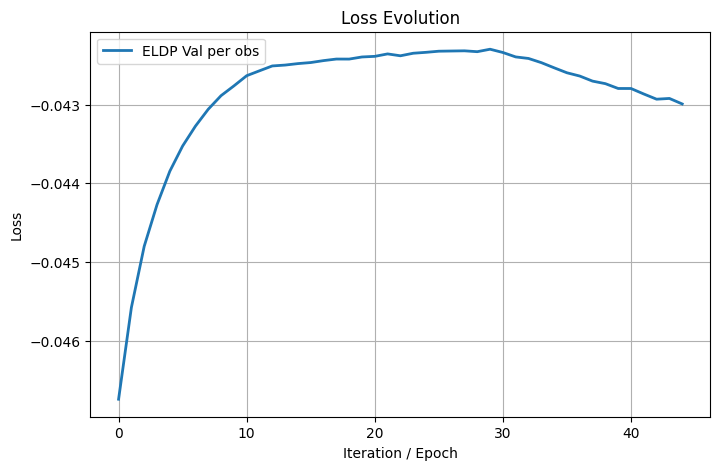

In [11]:
elbo= output['loss_history']
#loss_history = output['ll_history']
val_loss = output['val_history']



# Plot            
plt.figure(figsize=(8, 5))
plt.plot(val_loss, label="ELDP Val per obs", linewidth=2)
plt.xlabel("Iteration / Epoch")
plt.ylabel("Loss")
plt.title("Loss Evolution")
plt.legend()
plt.grid(True)
plt.show()

### 4. Compare to Benchmarks

We compare the learned GTM to a Gaussian Approximation and the Oracle Model. We expect the GTM to lie between these two in terms of approximation the true underlying distribution.
We measure this by means of the Kullback Leibler Divergence which we approximate on the test set which is equivalent to the log likelihood ratio between the true distribution and an approximation of it..

In [12]:
log_likelihood_train_bgtm = model.log_likelihood(simulated_data_train)
log_likelihood_validate_bgtm = model.log_likelihood(simulated_data_validate)
log_likelihood_test_bgtm = model.log_likelihood(simulated_data_test)


log_likelihood_train_gtm = model_freq.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model_freq.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model_freq.log_likelihood(simulated_data_test)

In [13]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = (mvn_model.log_prob(simulated_data_train)).to(device)
log_likelihood_validate_gaussian = (mvn_model.log_prob(simulated_data_validate)).to(device)
log_likelihood_test_gaussian = (mvn_model.log_prob(simulated_data_test)).to(device)


In [14]:
print("KLD BGTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_bgtm).item(),4) )
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )
print("")
print("KLD BGTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_bgtm).item(),4) )
print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD BGTM      Train Data:  0.076
KLD GTM      Train Data:  0.0032
KLD Gaussian Train Data:  0.0988
KLD Copula   Train Data:  -0.0001

KLD BGTM      Test  Data:  0.0796
KLD GTM      Test  Data:  0.0098
KLD Gaussian Test  Data:  0.1095
KLD Copula   Test  Data:  0.0017


### 5. Evaluate and Plot GTM Results

We evaluate the model further by showing how to generate synthetic samples, plot the conditional correlation patterns as well as the model splines.

Note that to generate synthetic samples the inverse of the trainsformation layer needs to be approximated  with the method `approximate_transformation_inverse` once which is then stored for future sampling. 

In [15]:
model.approximate_transformation_inverse()
synthetic_samples = model.sample(10000)
model_freq.approximate_transformation_inverse()
synthetic_samples_freq = model_freq.sample(10000)

../aten/src/ATen/native/cuda/ScatterGatherKernel.cu:144: operator(): block: [72,0,0], thread: [85,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/ScatterGatherKernel.cu:144: operator(): block: [72,0,0], thread: [86,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/ScatterGatherKernel.cu:144: operator(): block: [72,0,0], thread: [87,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


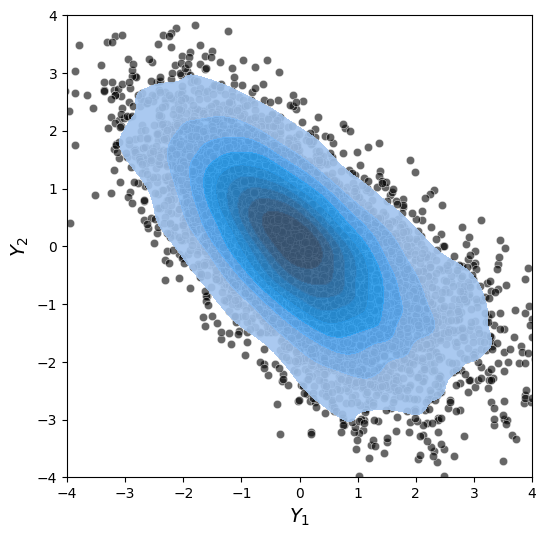

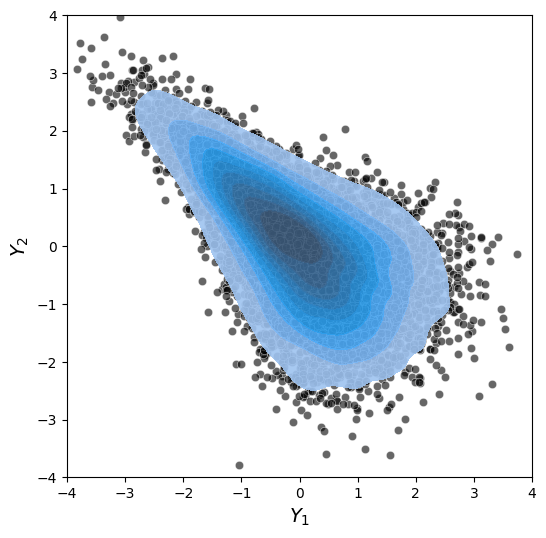

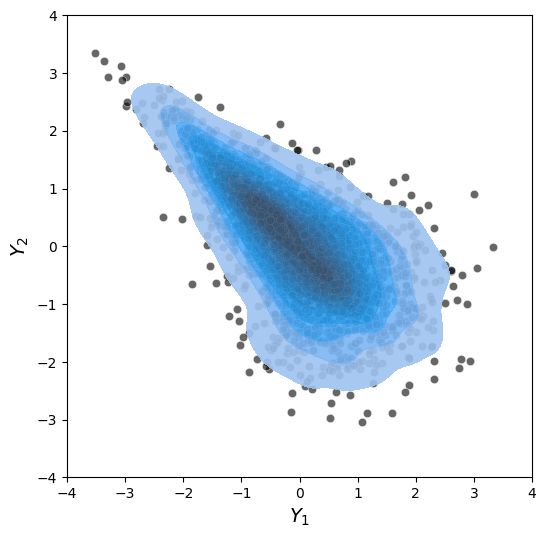

In [16]:
model.plot_densities(synthetic_samples.cpu(), x_lim=[-4,4], y_lim=[-4,4])
model_freq.plot_densities(synthetic_samples_freq.cpu(), x_lim=[-4,4], y_lim=[-4,4])
model.plot_densities(simulated_data_train.cpu(), x_lim=[-4,4], y_lim=[-4,4])

The varying pseudo conditional correlation matrix values can be computed for any synthetic samples using `compute_pseudo_conditional_correlation_matrix` or can directly be plotted using `plot_conditional_dependence_structure`.
The pseudo conditional correlation matrix is the standardised precision matrix so that off diagonal elements are the pseudo conditional correlations between the respective dimensions.

In [17]:
pseudo_conditional_correlation_matrix = model.compute_pseudo_conditional_correlation_matrix(synthetic_samples)

In [18]:
model.plot_conditional_dependence_structure(data=synthetic_samples.detach().cpu())

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

One can also visualize the splines of each layer usign the function `plot_splines`. For the transformation layer we additionally include the dervaitive which is always positive due to the monotonically increasing constraint as well as the inverse which should lie exactly on the spline to visually confirm that the inverse sampling path works.

In [23]:
model.plot_splines(layer_type="transformation")

TypeError: expected TensorOptions(dtype=float, device=cpu, layout=Strided, requires_grad=false (default), pinned_memory=false (default), memory_format=(nullopt)) (got TensorOptions(dtype=float, device=cuda:0, layout=Strided, requires_grad=false (default), pinned_memory=false (default), memory_format=(nullopt)))

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


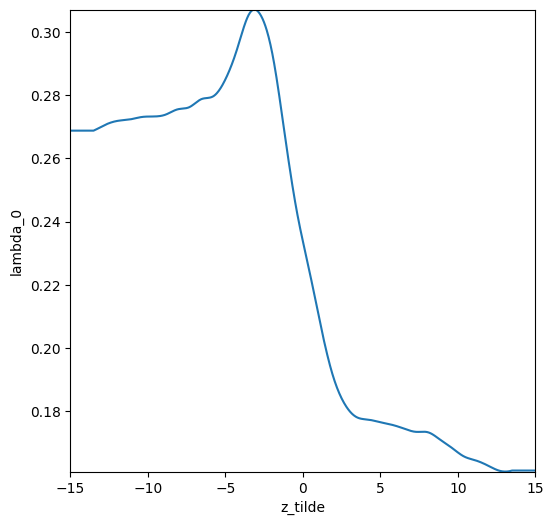

In [ ]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=0)

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


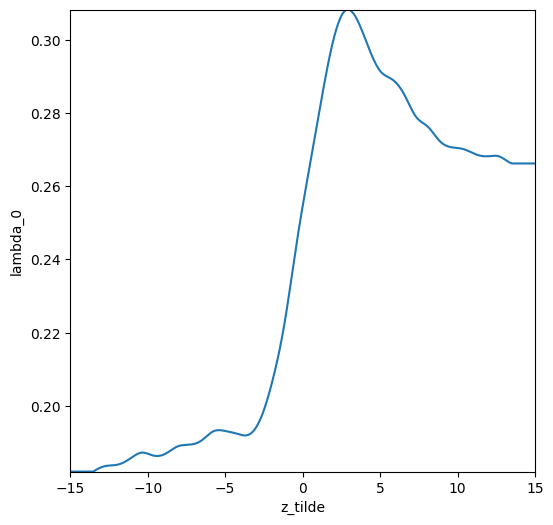

In [ ]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=1)

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


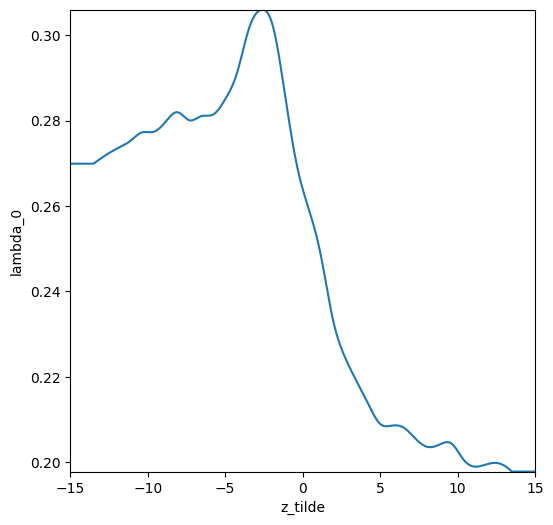

In [ ]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=2)